In [1]:
import torch

torch.manual_seed(0)    #A
observations = 2048
train_data = torch.zeros((observations, 2))    #B 

train_data[:,0]=50*torch.rand(observations)    #C

train_data[:,1]=1.08**train_data[:,0]    #D

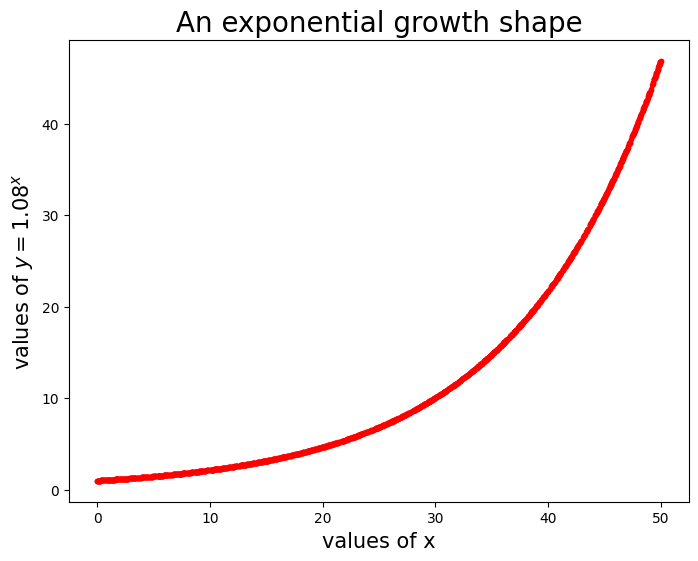

In [2]:
import matplotlib.pyplot as plt

fig=plt.figure(dpi=100,figsize=(8,6))
plt.plot(train_data[:,0],train_data[:,1],".",c="r")    #A
plt.xlabel("values of x",fontsize=15)
plt.ylabel("values of $y=1.08^x$",fontsize=15)    #B
plt.title("An exponential growth shape",fontsize=20)    #C
plt.show()

In [3]:
from torch.utils.data import DataLoader

batch_size=128
train_loader=DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True)

In [4]:
batch0=next(iter(train_loader))
print(batch0)

tensor([[41.9333, 25.2099],
        [ 8.0561,  1.8589],
        [22.2487,  5.5416],
        [49.9585, 46.7522],
        [ 8.7647,  1.9631],
        [ 3.0979,  1.2692],
        [26.0517,  7.4259],
        [38.2393, 18.9716],
        [37.1300, 17.4191],
        [45.0543, 32.0541],
        [ 8.7989,  1.9683],
        [20.4796,  4.8362],
        [46.7506, 36.5243],
        [21.8242,  5.3635],
        [11.2329,  2.3738],
        [40.3307, 22.2845],
        [47.0477, 37.3691],
        [47.6369, 39.1026],
        [16.2331,  3.4880],
        [11.7535,  2.4709],
        [12.8855,  2.6958],
        [20.6749,  4.9095],
        [ 4.6602,  1.4314],
        [26.3385,  7.5916],
        [31.7039, 11.4727],
        [45.5565, 33.3172],
        [41.3369, 24.0788],
        [26.8584,  7.9015],
        [14.9879,  3.1692],
        [33.7039, 13.3817],
        [47.7350, 39.3988],
        [31.7714, 11.5324],
        [ 7.4853,  1.7790],
        [14.5973,  3.0754],
        [31.4056, 11.2122],
        [35.8166, 15

In [5]:
import torch.nn as nn

device="cuda" if torch.cuda.is_available() else "cpu"

D=nn.Sequential(
    nn.Linear(2,256),    #A
    nn.ReLU(),
    nn.Dropout(0.3),    #B
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64,1),    #C
    nn.Sigmoid()).to(device)

In [6]:
G=nn.Sequential(
    nn.Linear(2,16),    #A
    nn.ReLU(),
    nn.Linear(16,32),
    nn.ReLU(),
    nn.Linear(32,2)).to(device)    #B

In [7]:
loss_fn=nn.BCELoss()
lr=0.0005
optimD=torch.optim.Adam(D.parameters(),lr=lr)
optimG=torch.optim.Adam(G.parameters(),lr=lr)

In [8]:
mse=nn.MSELoss()    #A

def performance(fake_samples):
    real=1.08**fake_samples[:,0]    #B
    mseloss=mse(fake_samples[:,1],real)   #C
    return mseloss


In [9]:
class EarlyStop:
    def __init__(self, patience=1000):    #A
        self.patience = patience
        self.steps = 0
        self.min_gdif = float('inf')
    def stop(self, gdif):    #B
        if gdif < self.min_gdif:    #C
            self.min_gdif = gdif
            self.steps = 0
        elif gdif >= self.min_gdif:
            self.steps += 1
        if self.steps >= self.patience:    #D
            return True
        else:
            return False

stopper=EarlyStop()

In [10]:
real_labels=torch.ones((batch_size,1))
real_labels=real_labels.to(device)

fake_labels=torch.zeros((batch_size,1))
fake_labels=fake_labels.to(device)

In [11]:
def train_D_on_real(real_samples):
    real_samples=real_samples.to(device)
    optimD.zero_grad()
    out_D=D(real_samples)    #A
    loss_D=loss_fn(out_D,real_labels)    #B
    loss_D.backward()
    optimD.step()    #C
    return loss_D

In [12]:
def train_D_on_fake():        
    noise=torch.randn((batch_size,2))
    noise=noise.to(device)
    fake_samples=G(noise)     #A       
    optimD.zero_grad()
    out_D=D(fake_samples)    #B
    loss_D=loss_fn(out_D,fake_labels)    #C
    loss_D.backward()
    optimD.step()    #D
    return loss_D

In [13]:
def train_G(): 
    noise=torch.randn((batch_size,2))
    noise=noise.to(device)
    optimG.zero_grad()
    fake_samples=G(noise)    #A
    out_G=D(fake_samples)    #B
    loss_G=loss_fn(out_G,real_labels)    #C
    loss_G.backward()
    optimG.step()     #D
    return loss_G, fake_samples 

In [14]:
import os
os.makedirs("files", exist_ok=True)    #A

def test_epoch(epoch,gloss,dloss,n,fake_samples):
    if epoch==0 or (epoch+1)%25==0:
        g=gloss.item()/n
        d=dloss.item()/n
        print(f"at epoch {epoch+1}, G loss: {g}, D loss {d}")    #B 
        fake=fake_samples.detach().cpu().numpy()
        plt.figure(dpi=200)
        plt.plot(fake[:,0],fake[:,1],"*",c="g",
            label="generated samples")    #C
        plt.plot(train_data[:,0],train_data[:,1],".",c="r",
            alpha=0.1,label="real samples")    #D
        plt.title(f"epoch {epoch+1}")
        plt.xlim(0,50)
        plt.ylim(0,50)
        plt.legend()
        plt.savefig(f"files/p{epoch+1}.png")
        plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

at epoch 1, G loss: 0.7864417394002279, D loss 0.8396333058675131


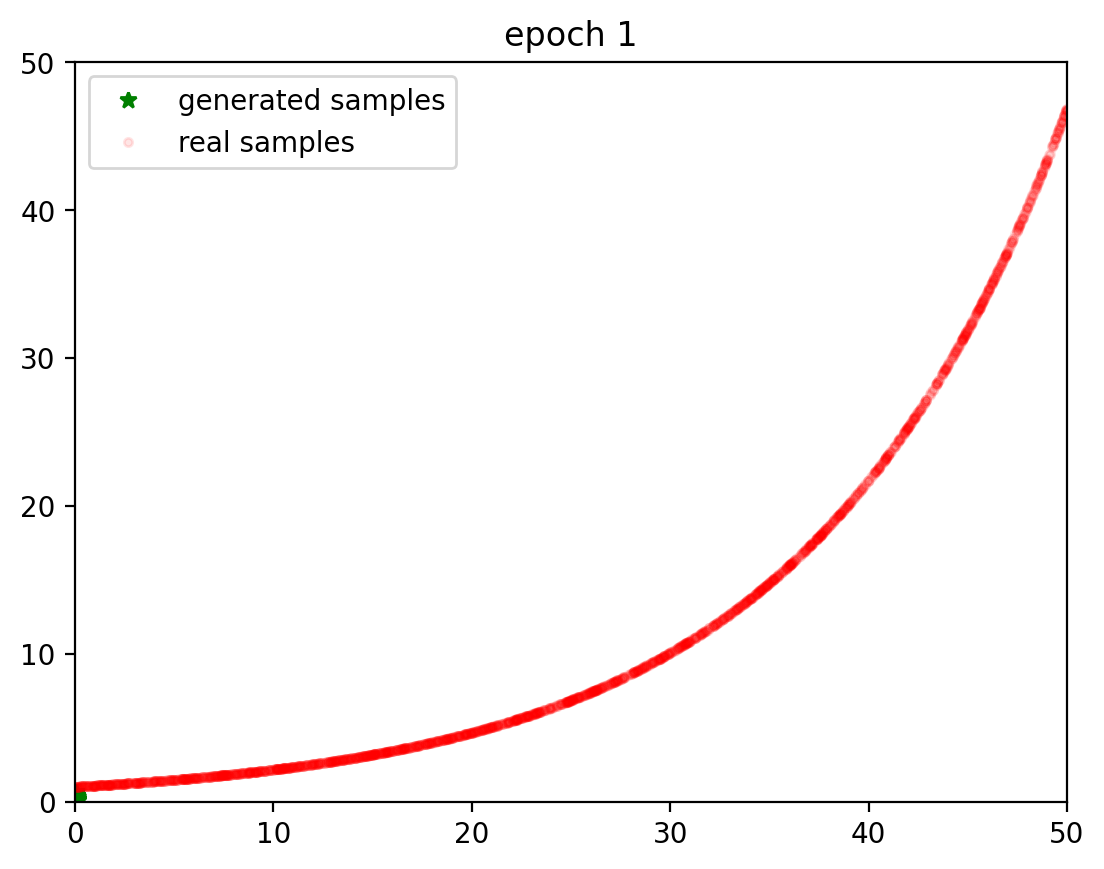

  0%|          | 24/10000 [00:04<24:46,  6.71it/s]

at epoch 25, G loss: 2.5360425313313804, D loss 0.45773531595865885


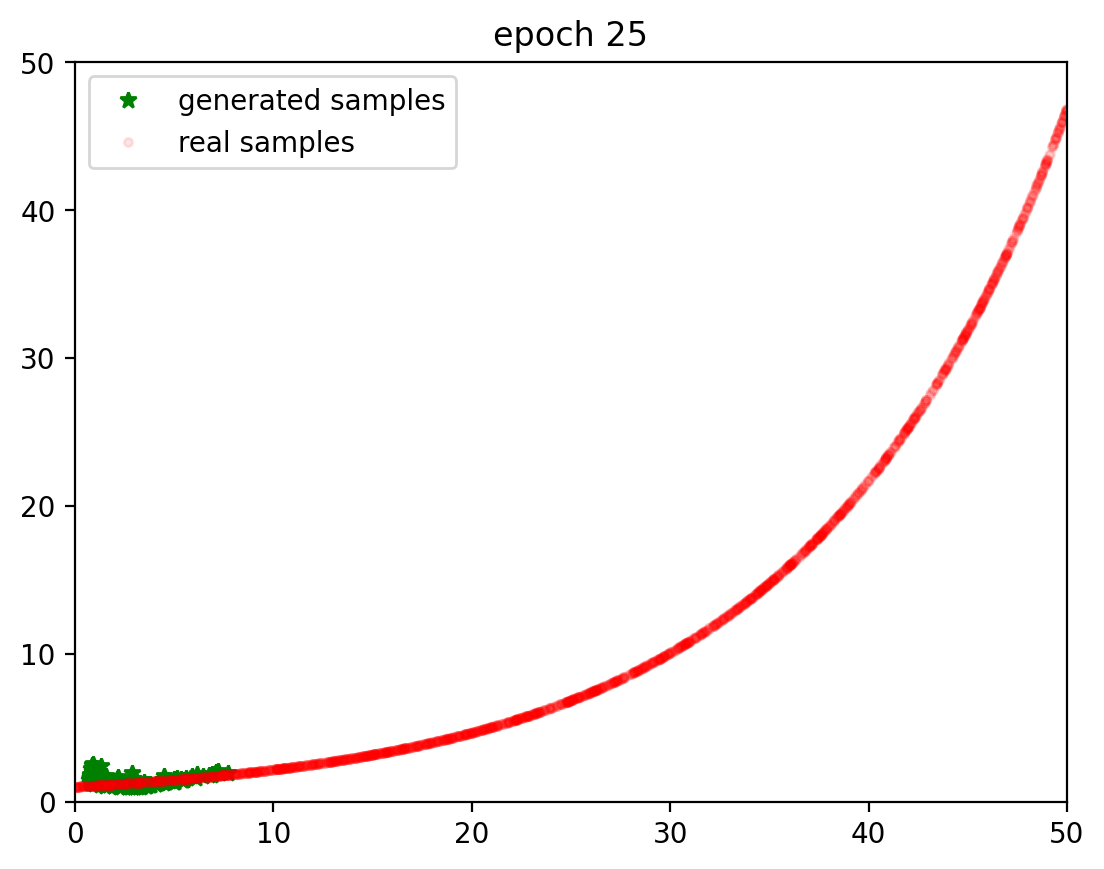

  0%|          | 49/10000 [00:08<26:00,  6.38it/s]

at epoch 50, G loss: 1.4282727559407553, D loss 0.9334136962890625


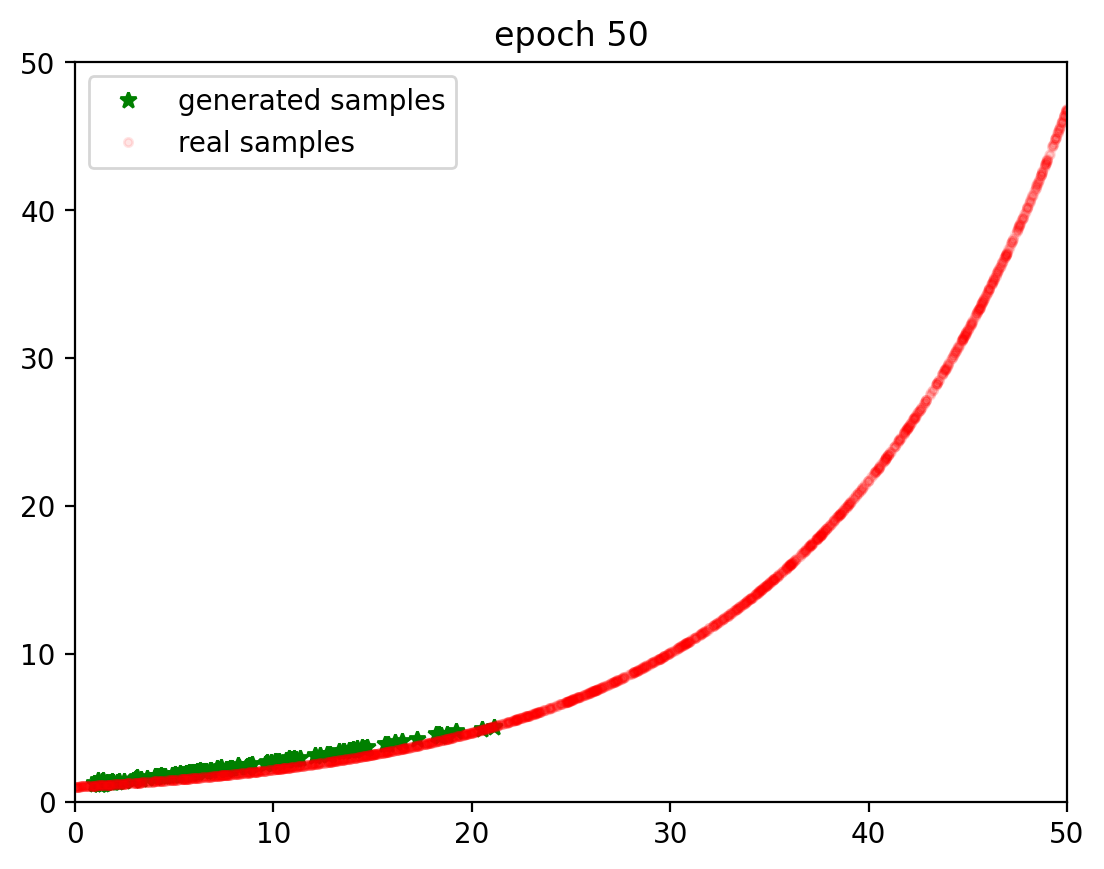

  1%|          | 74/10000 [00:13<32:11,  5.14it/s]

at epoch 75, G loss: 1.181170654296875, D loss 1.0378289540608725


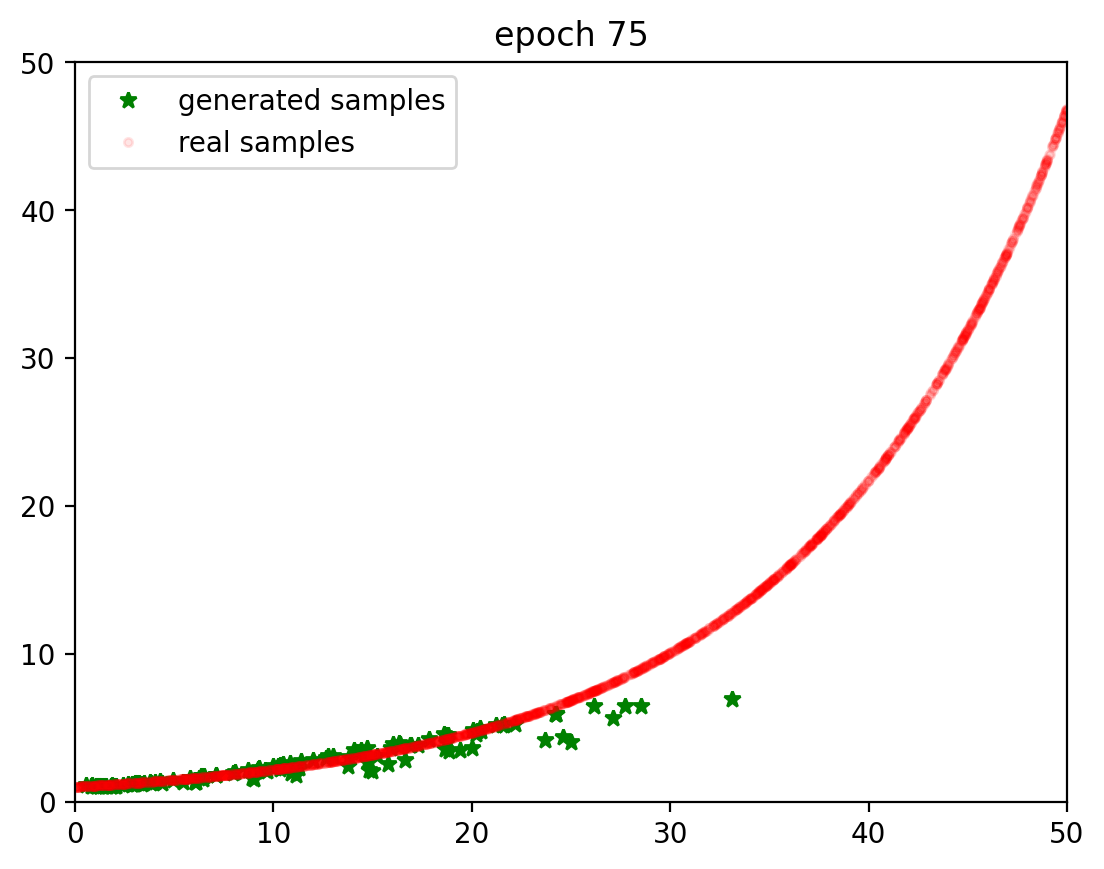

  1%|          | 99/10000 [00:18<27:27,  6.01it/s]

at epoch 100, G loss: 1.1254257202148437, D loss 1.0863131205240886


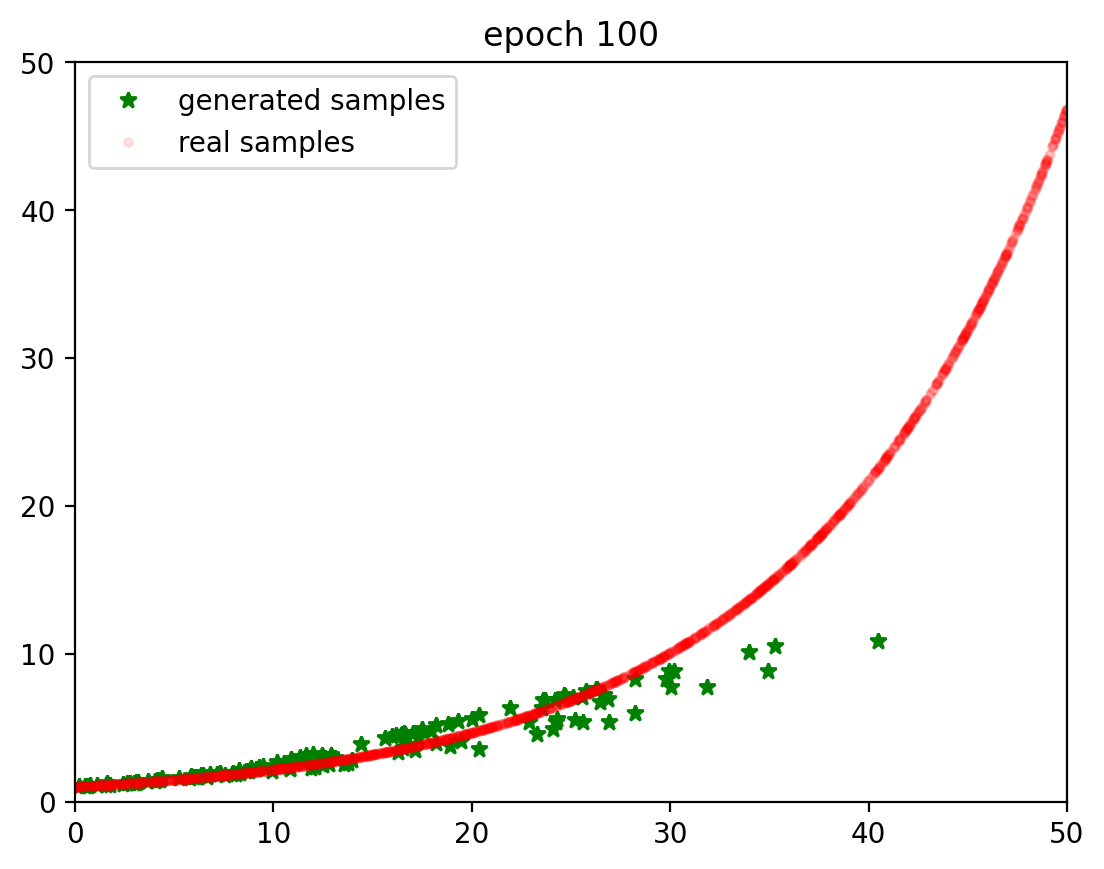

  1%|          | 124/10000 [00:22<26:16,  6.26it/s]

at epoch 125, G loss: 1.0581233978271485, D loss 1.1434073130289713


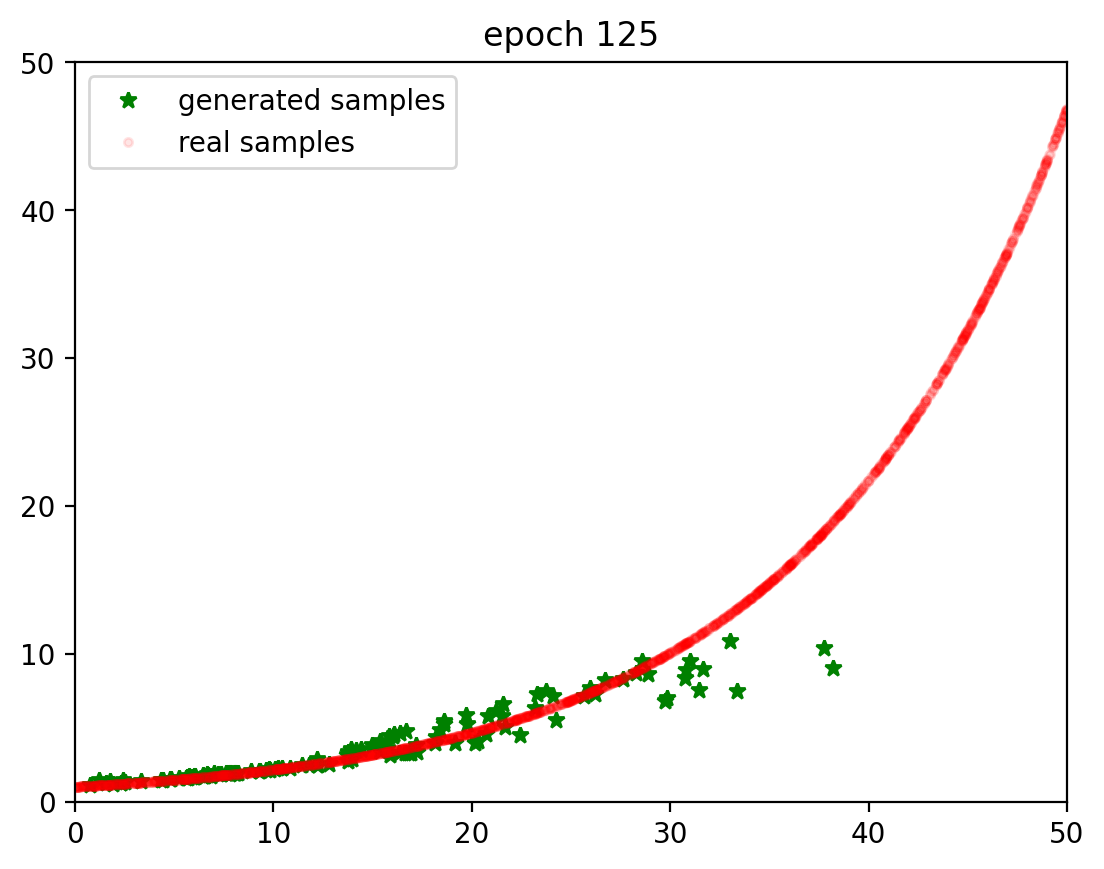

  1%|▏         | 149/10000 [00:27<26:47,  6.13it/s]

at epoch 150, G loss: 0.9301293690999349, D loss 1.285987345377604


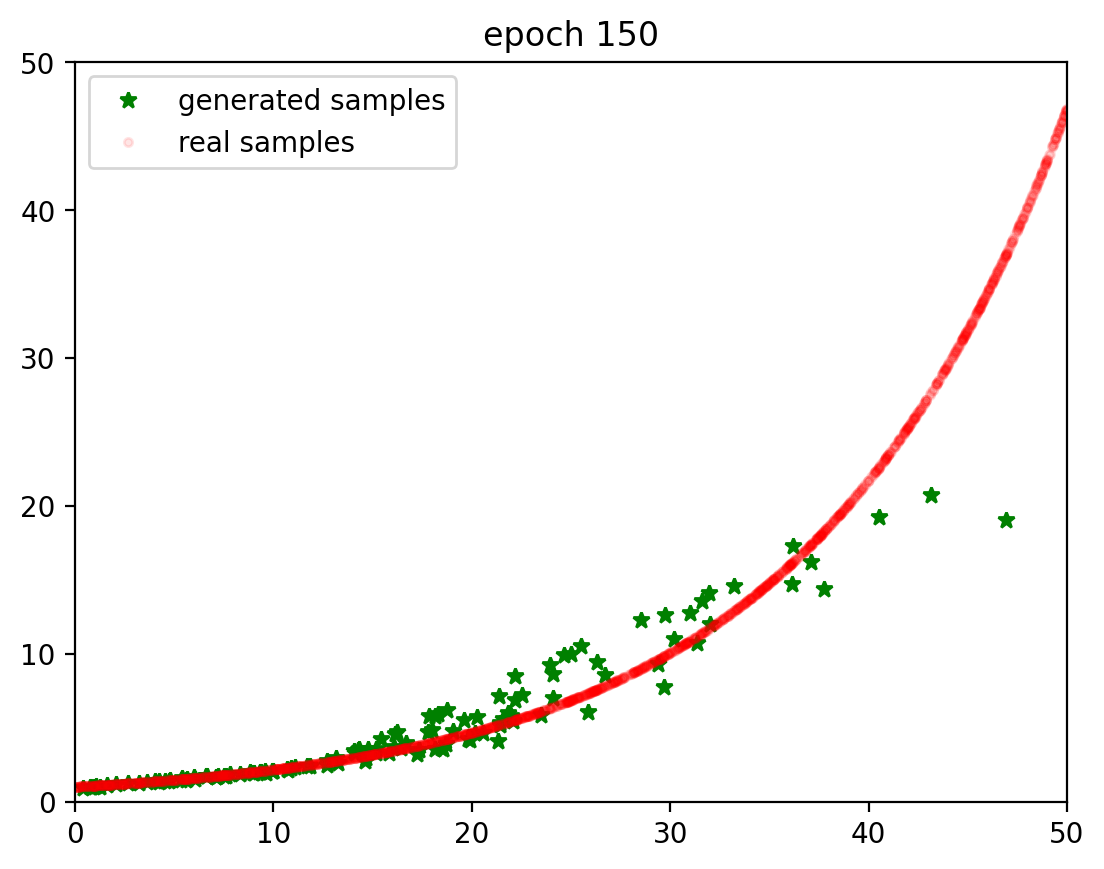

  2%|▏         | 174/10000 [00:31<26:12,  6.25it/s]

at epoch 175, G loss: 0.869145393371582, D loss 1.3582271575927733


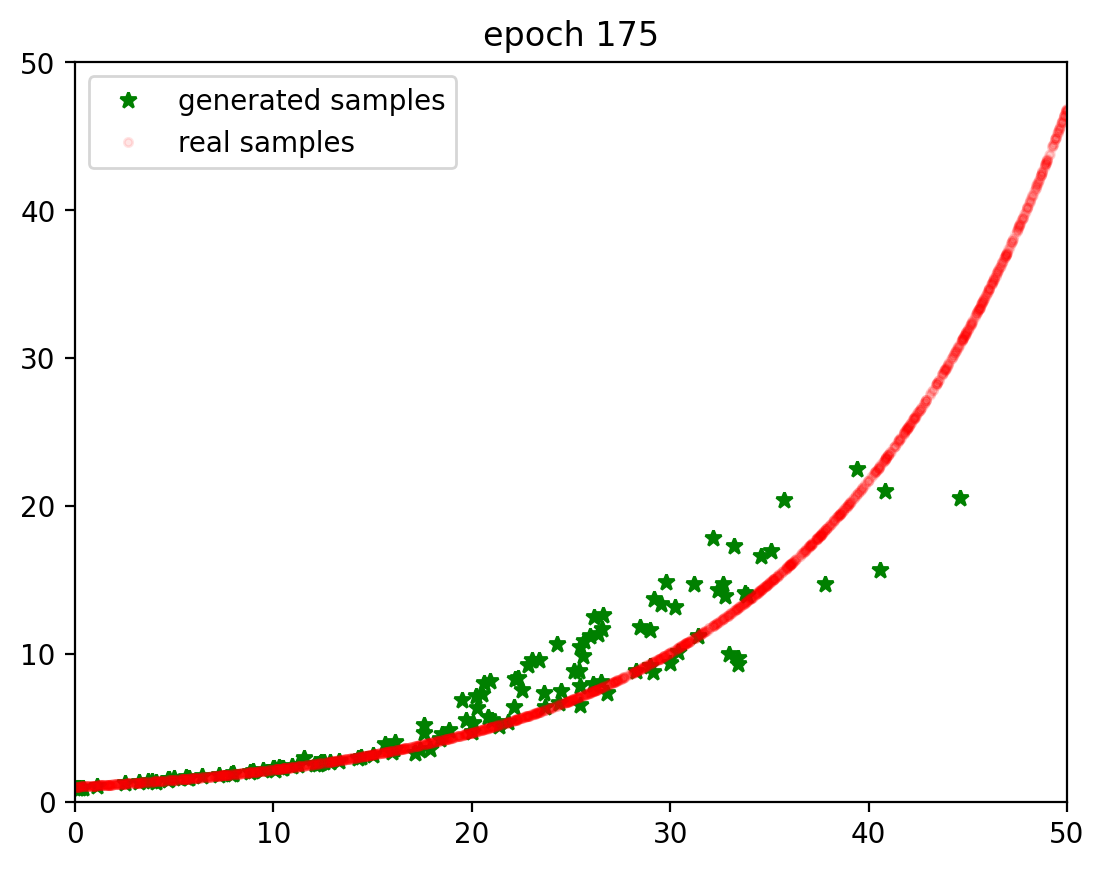

  2%|▏         | 199/10000 [00:36<26:19,  6.21it/s]

at epoch 200, G loss: 0.8094154357910156, D loss 1.4219590504964192


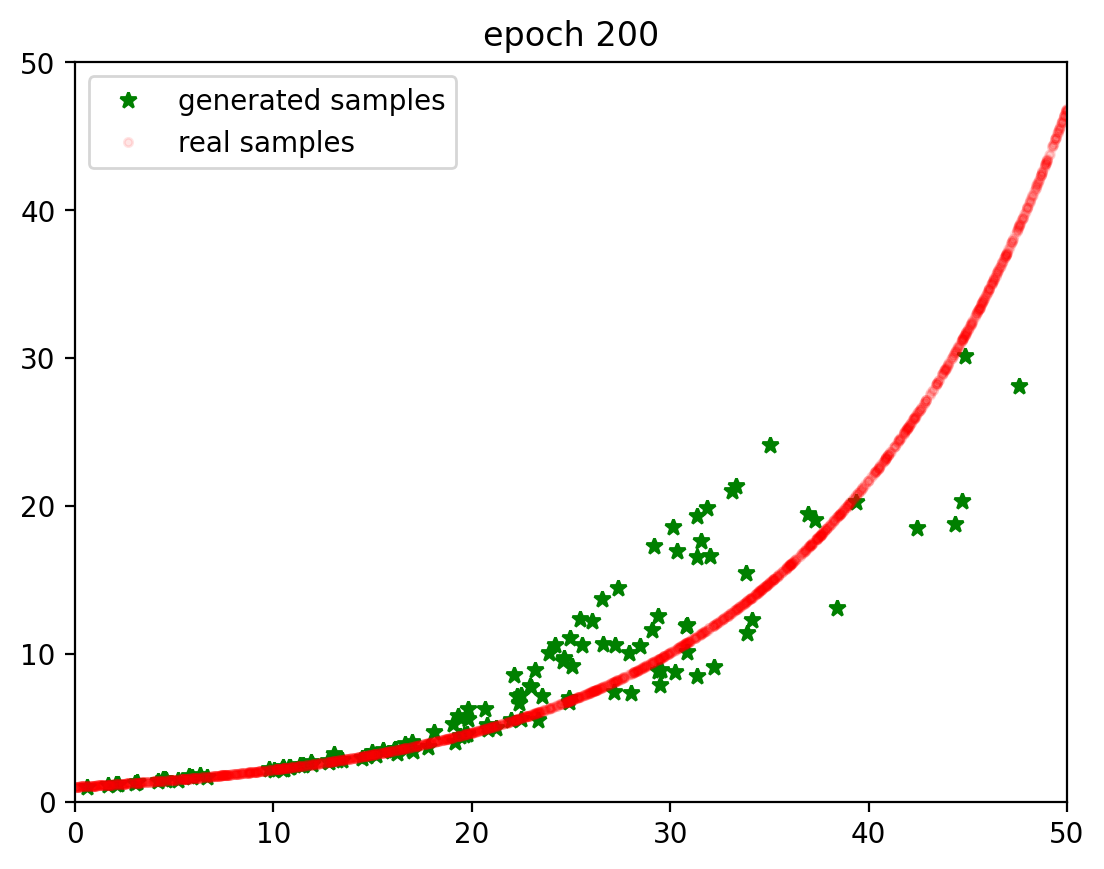

  2%|▏         | 224/10000 [00:40<27:22,  5.95it/s]

at epoch 225, G loss: 0.7958274841308594, D loss 1.464177703857422


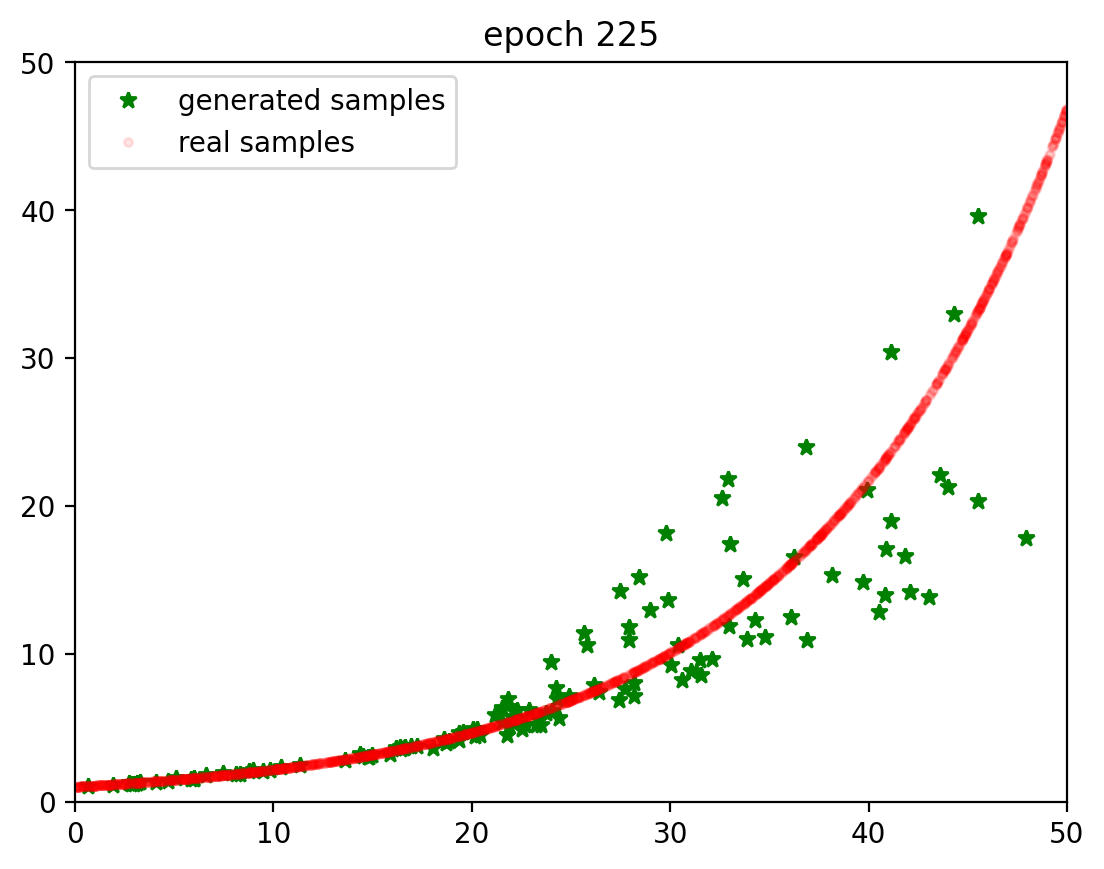

  2%|▏         | 249/10000 [00:45<36:29,  4.45it/s]

at epoch 250, G loss: 0.7778568267822266, D loss 1.469281005859375


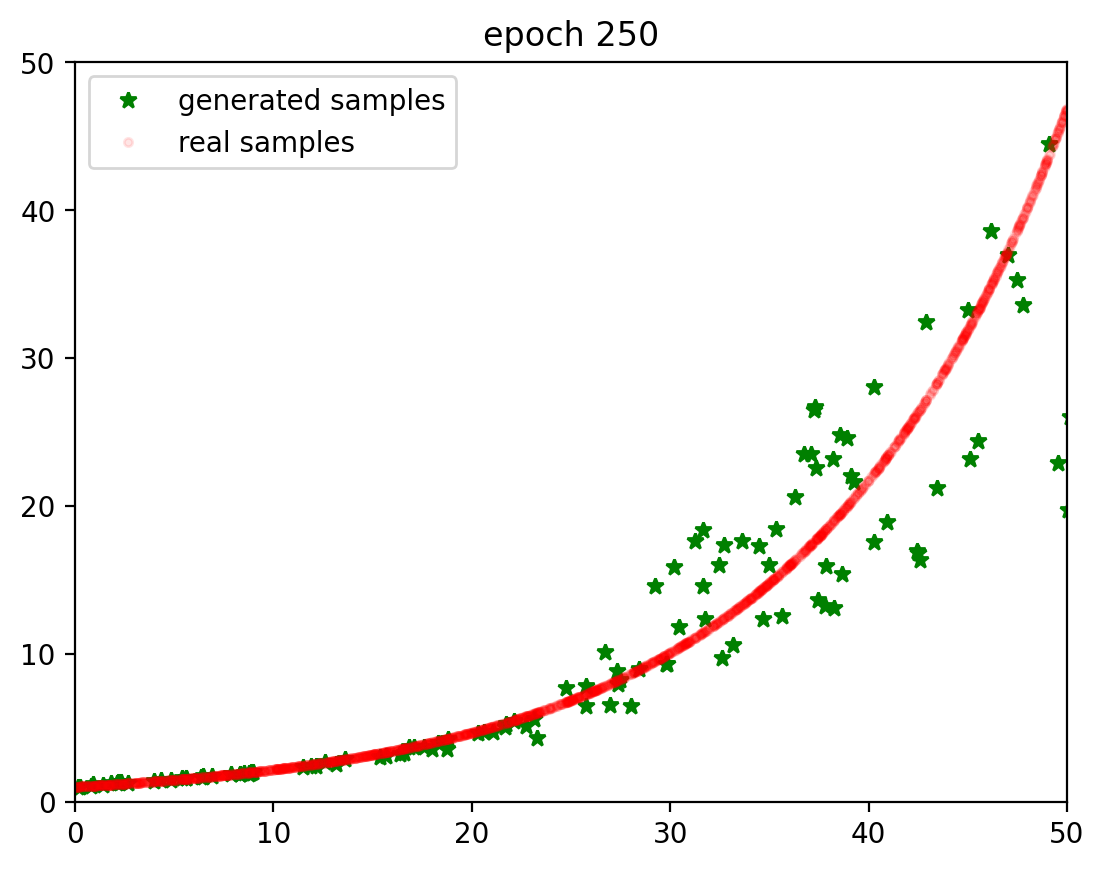

  3%|▎         | 274/10000 [00:50<27:04,  5.99it/s]

at epoch 275, G loss: 0.7794124603271484, D loss 1.476142374674479


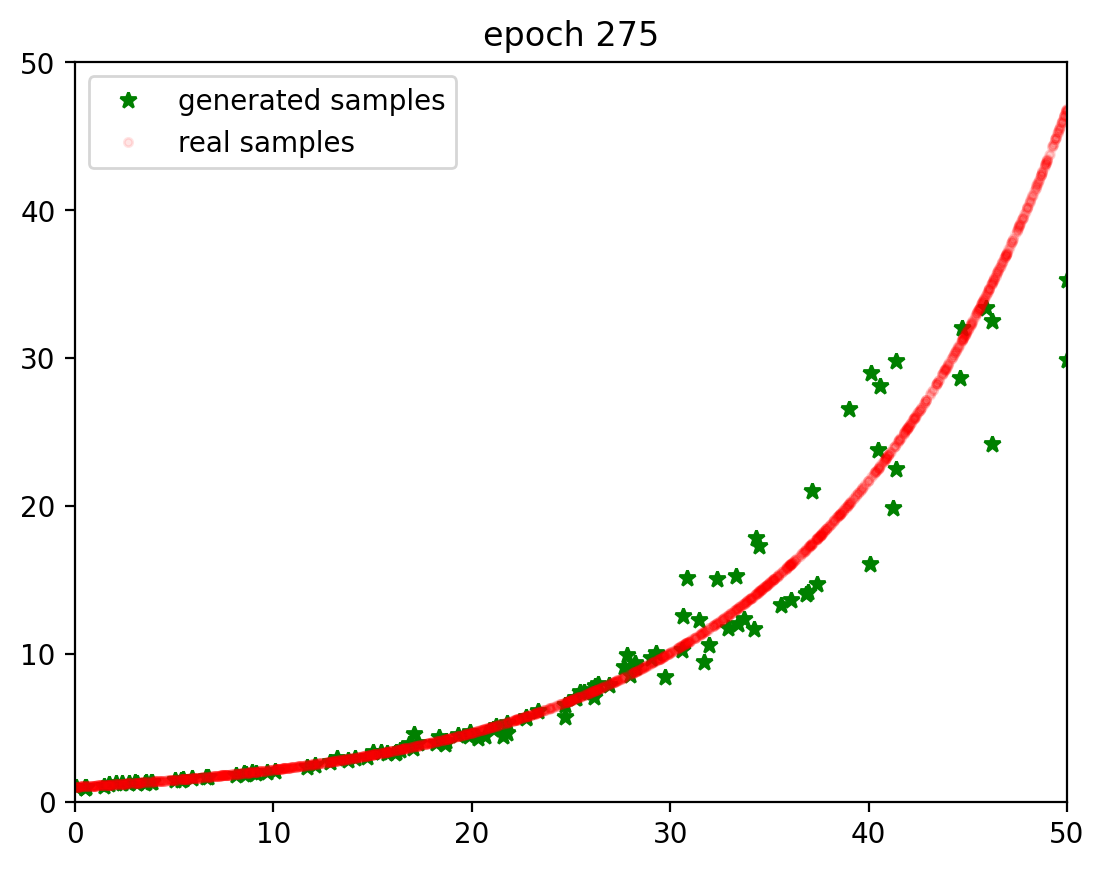

  3%|▎         | 299/10000 [00:55<29:41,  5.44it/s]

at epoch 300, G loss: 0.7731865564982097, D loss 1.4800217946370442


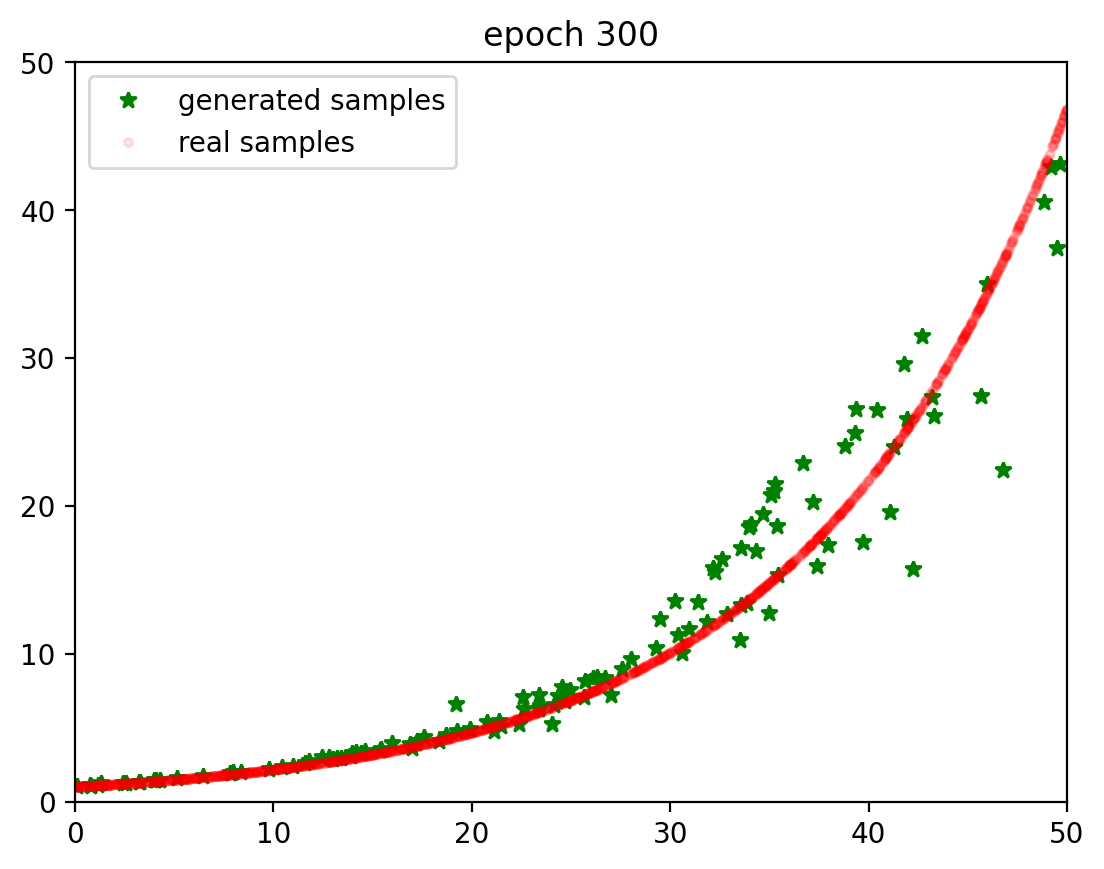

  3%|▎         | 324/10000 [00:59<26:20,  6.12it/s]

at epoch 325, G loss: 0.7593326568603516, D loss 1.478442637125651


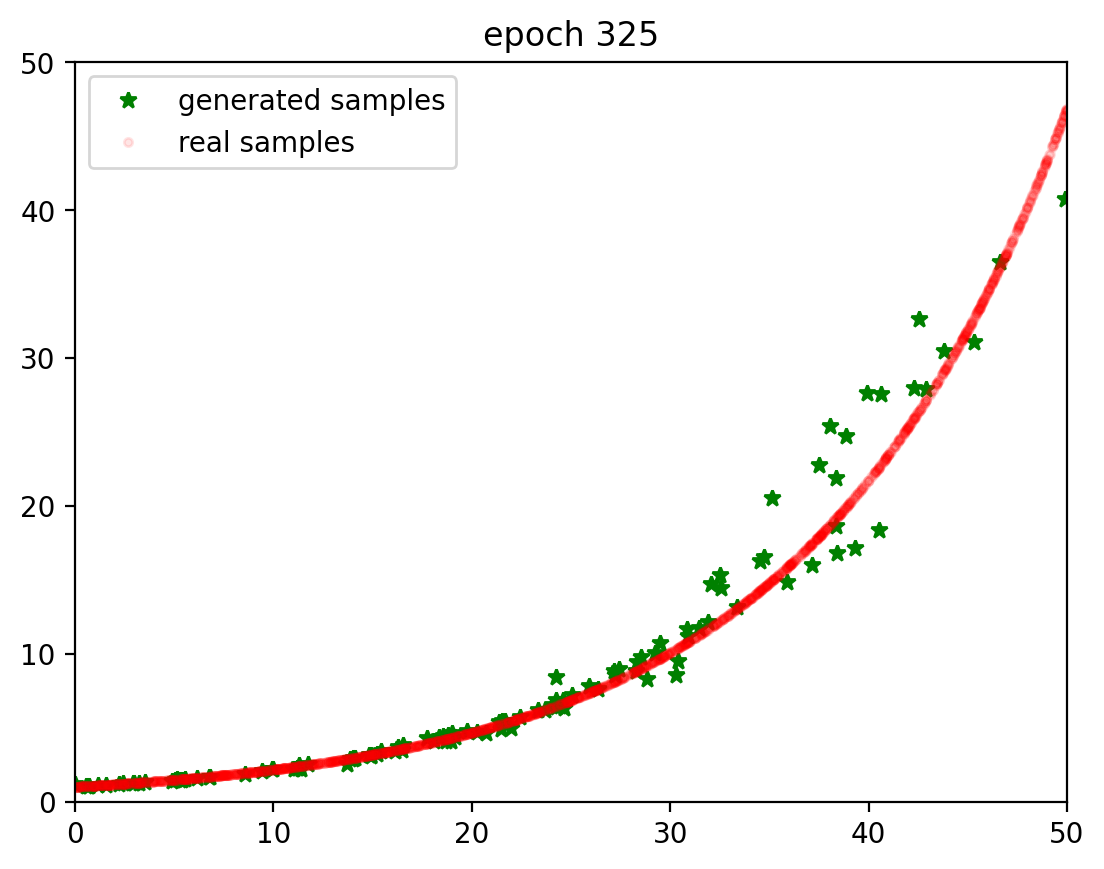

  3%|▎         | 349/10000 [01:04<26:09,  6.15it/s]

at epoch 350, G loss: 0.7553475697835287, D loss 1.4768152872721354


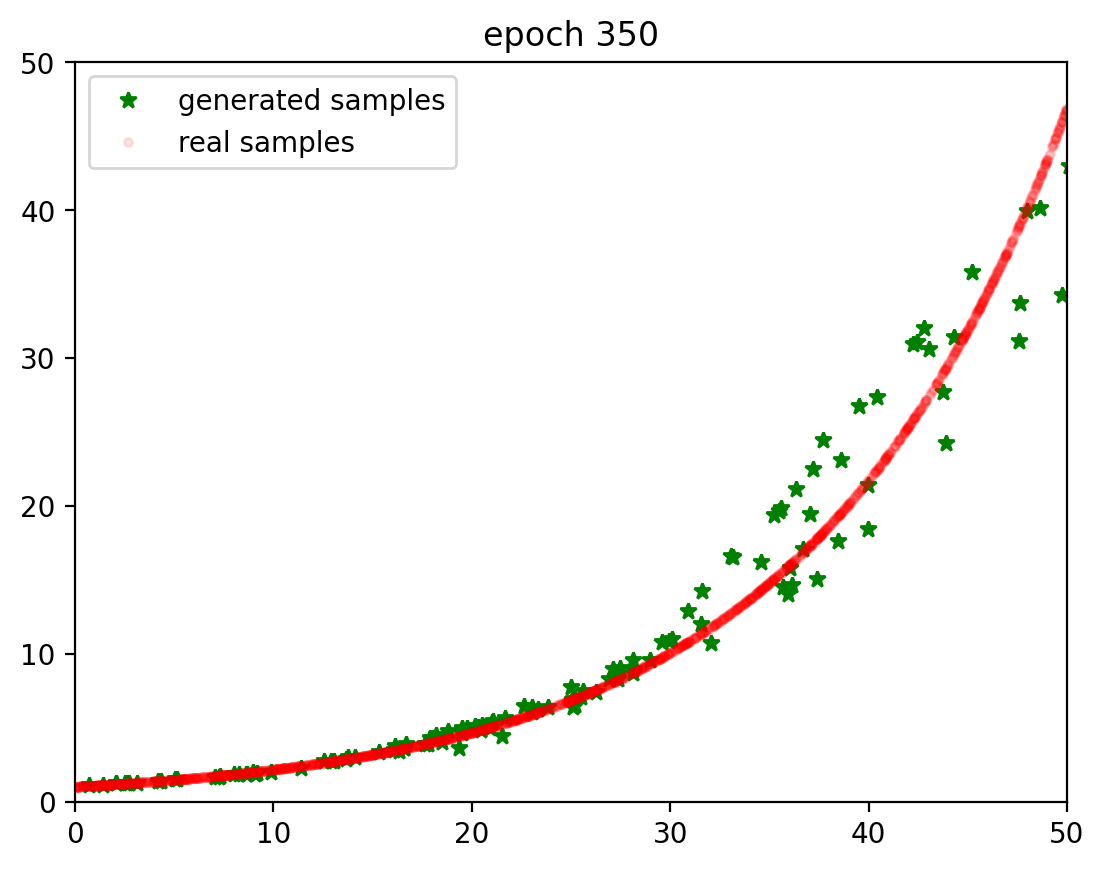

  4%|▎         | 374/10000 [01:09<26:42,  6.01it/s]

at epoch 375, G loss: 0.7557550430297851, D loss 1.4796007792154948


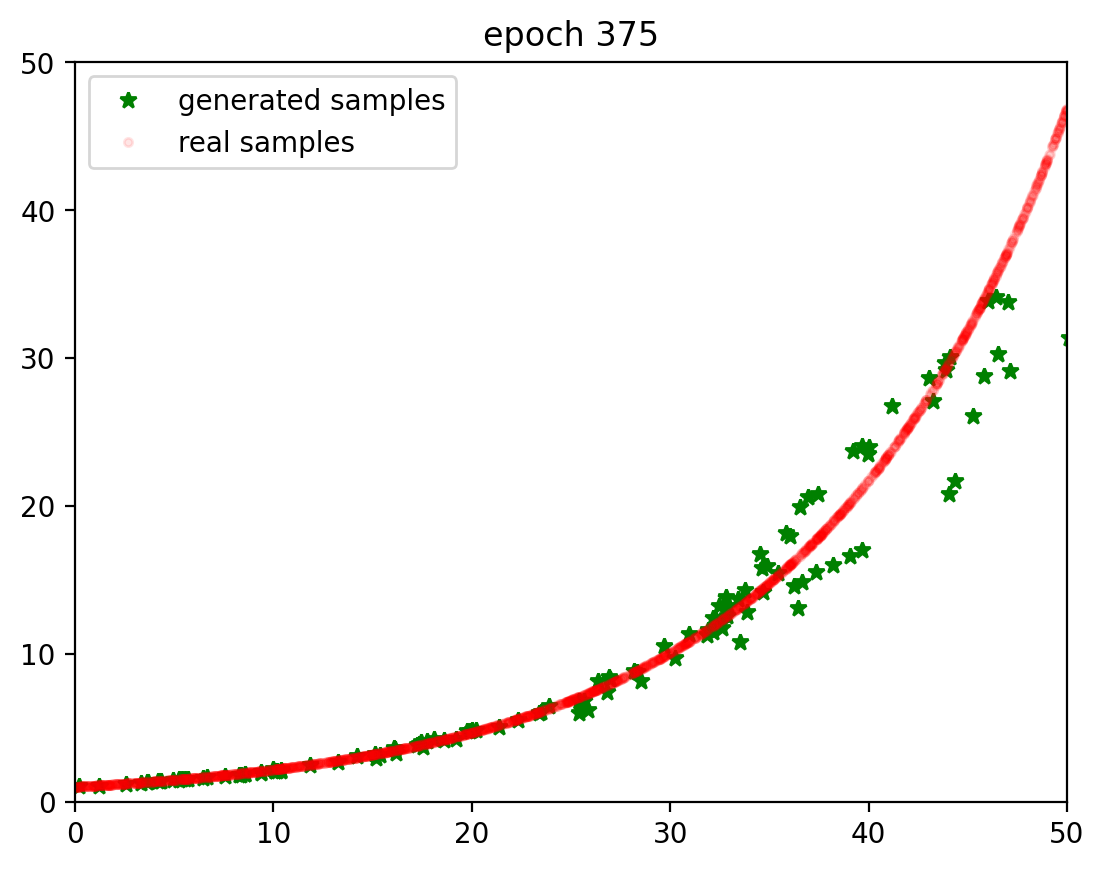

  4%|▍         | 399/10000 [01:13<25:30,  6.27it/s]

at epoch 400, G loss: 0.7674389521280924, D loss 1.4741111755371095


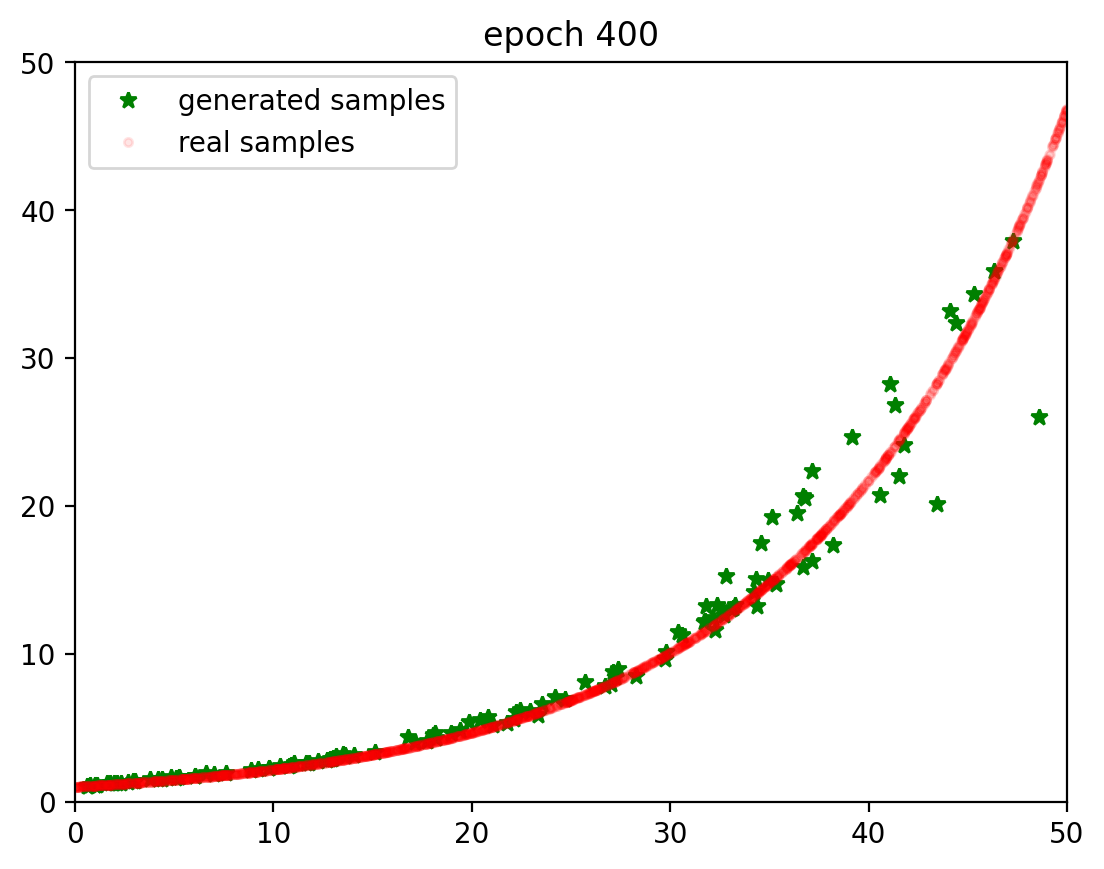

  4%|▍         | 424/10000 [01:18<27:05,  5.89it/s]

at epoch 425, G loss: 0.7672587712605794, D loss 1.4753223419189454


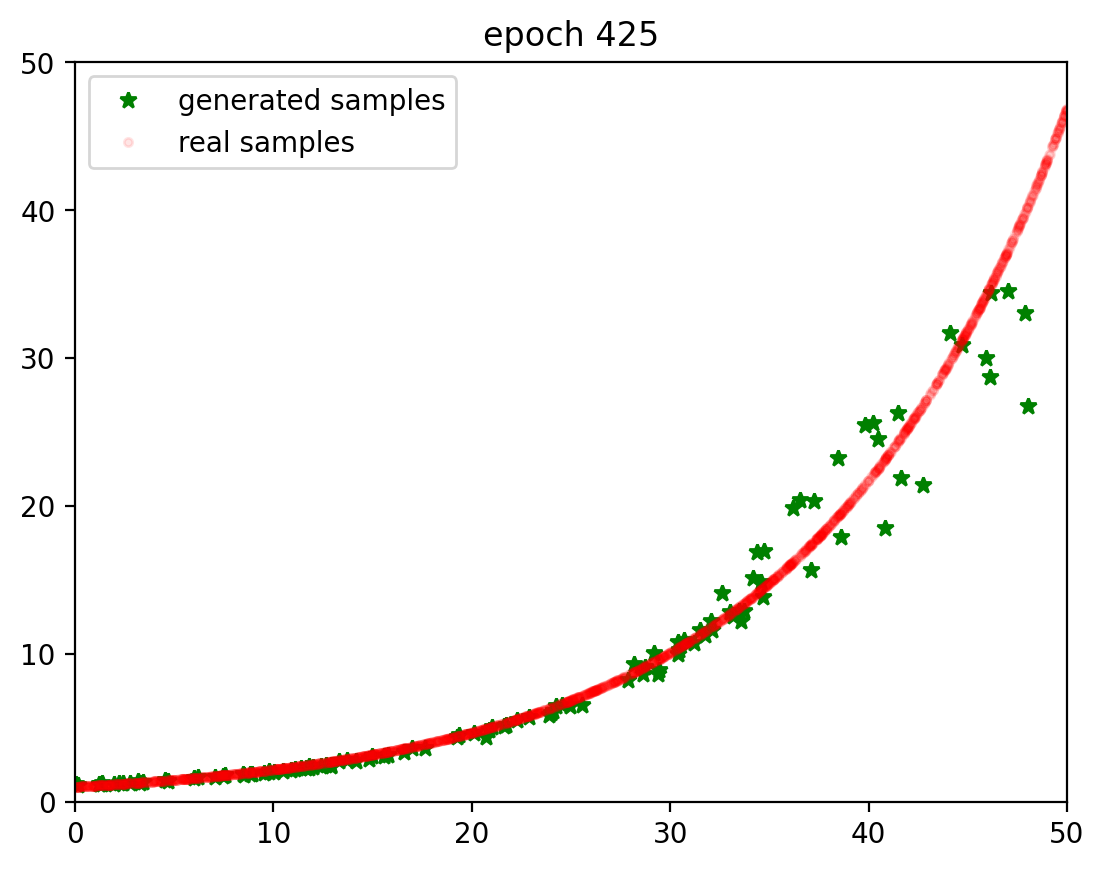

  4%|▍         | 449/10000 [01:23<26:05,  6.10it/s]

at epoch 450, G loss: 0.7521919250488281, D loss 1.4791584014892578


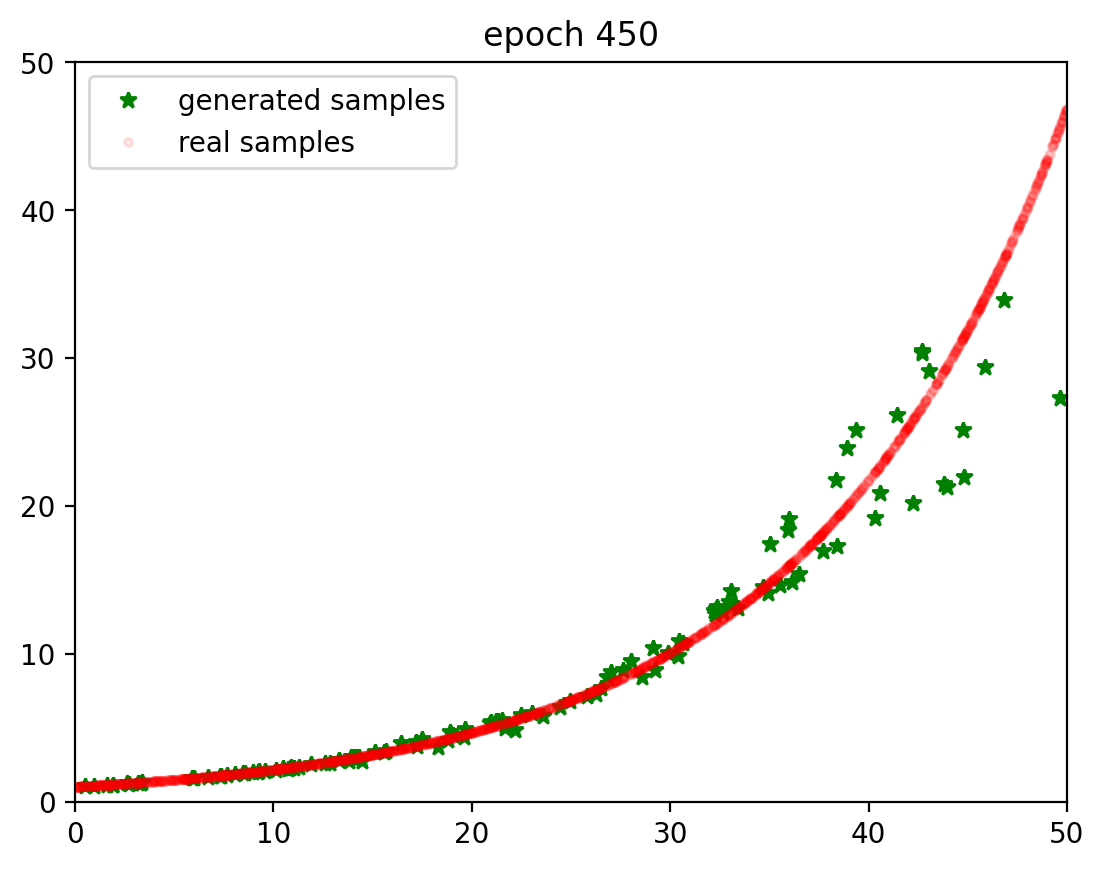

  5%|▍         | 474/10000 [01:28<26:32,  5.98it/s]

at epoch 475, G loss: 0.7530451456705729, D loss 1.4704315185546875


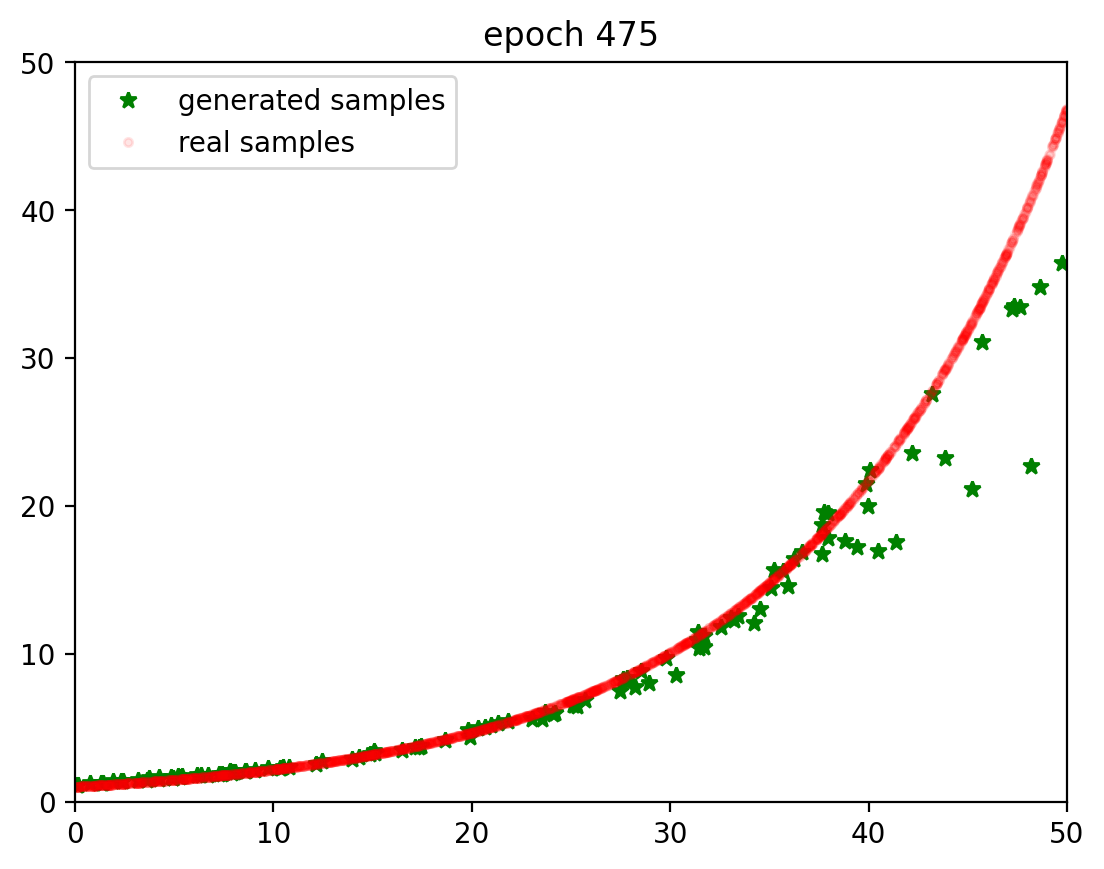

  5%|▍         | 499/10000 [01:32<26:53,  5.89it/s]

at epoch 500, G loss: 0.7645440419514974, D loss 1.473855972290039


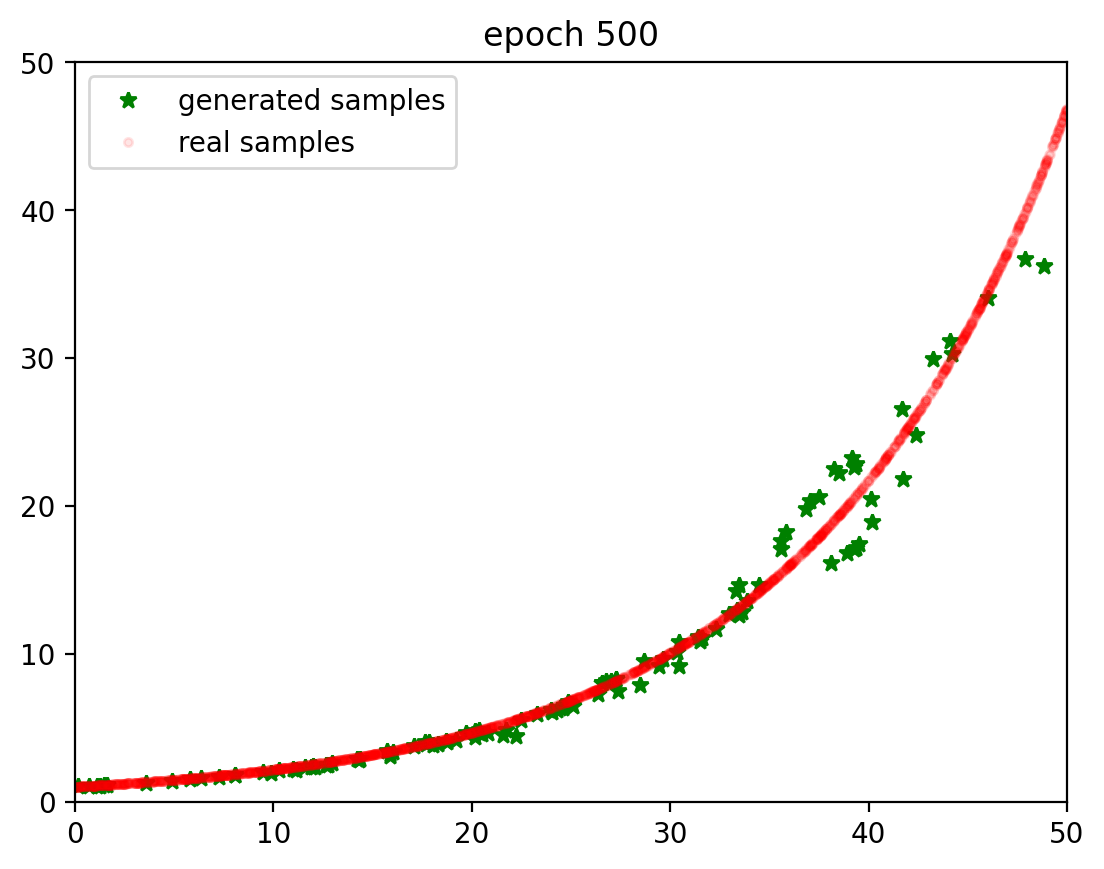

  5%|▌         | 524/10000 [01:37<26:02,  6.07it/s]

at epoch 525, G loss: 0.7537025451660156, D loss 1.4788948059082032


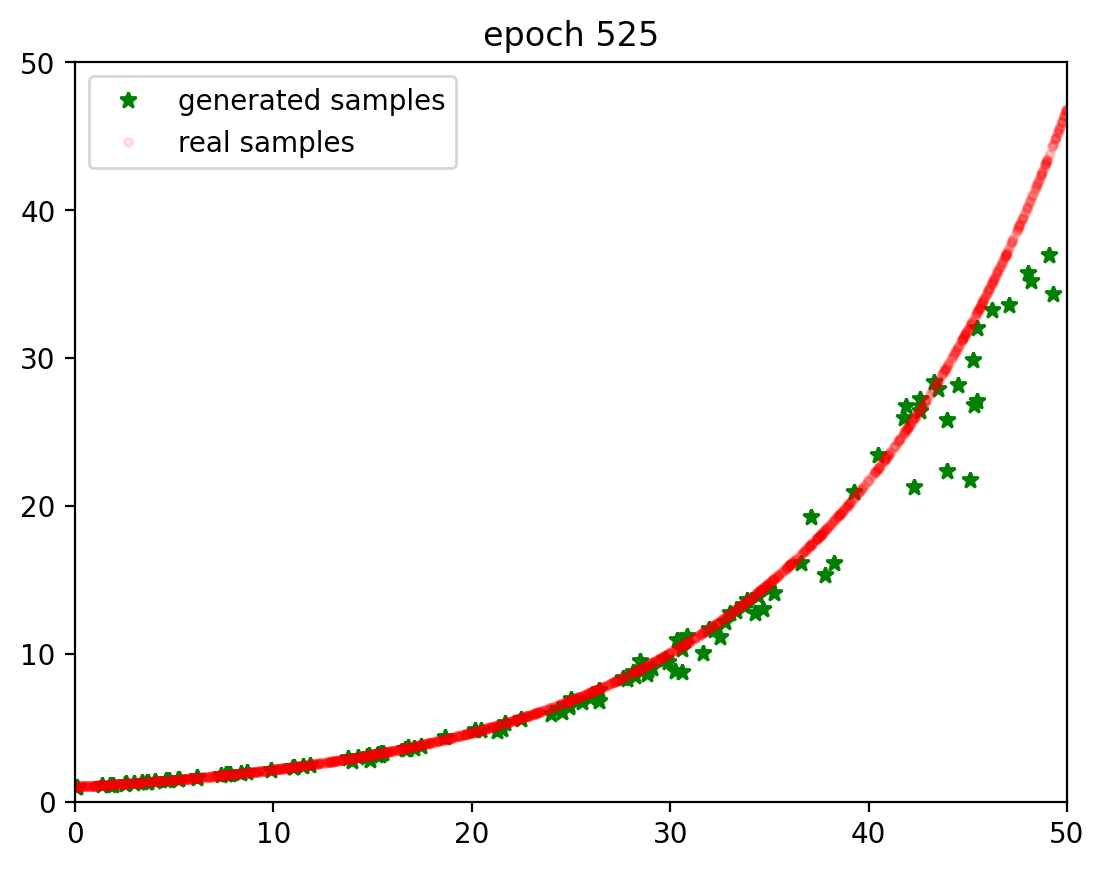

  5%|▌         | 549/10000 [01:42<26:05,  6.04it/s]

at epoch 550, G loss: 0.7610102335611979, D loss 1.478375244140625


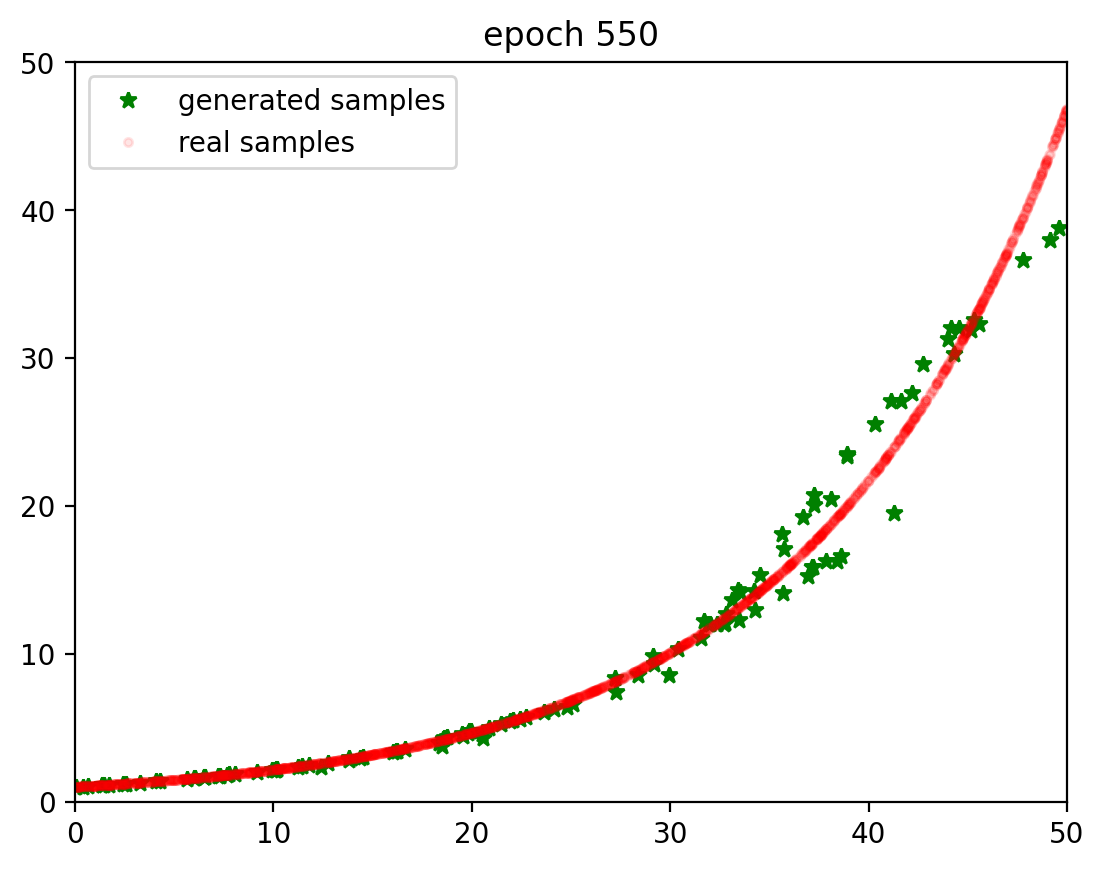

  6%|▌         | 574/10000 [01:46<26:13,  5.99it/s]

at epoch 575, G loss: 0.755648676554362, D loss 1.4737311045328776


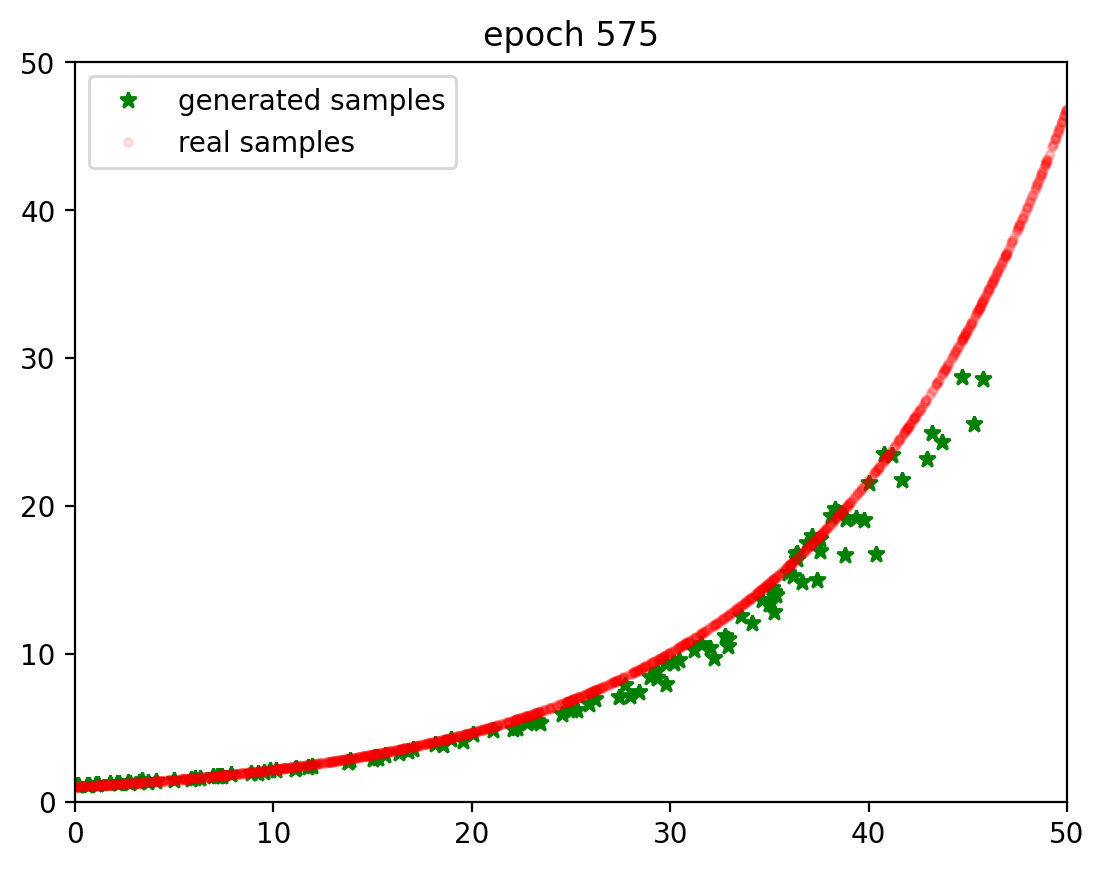

  6%|▌         | 599/10000 [01:51<26:10,  5.99it/s]

at epoch 600, G loss: 0.7628697713216146, D loss 1.4774152119954427


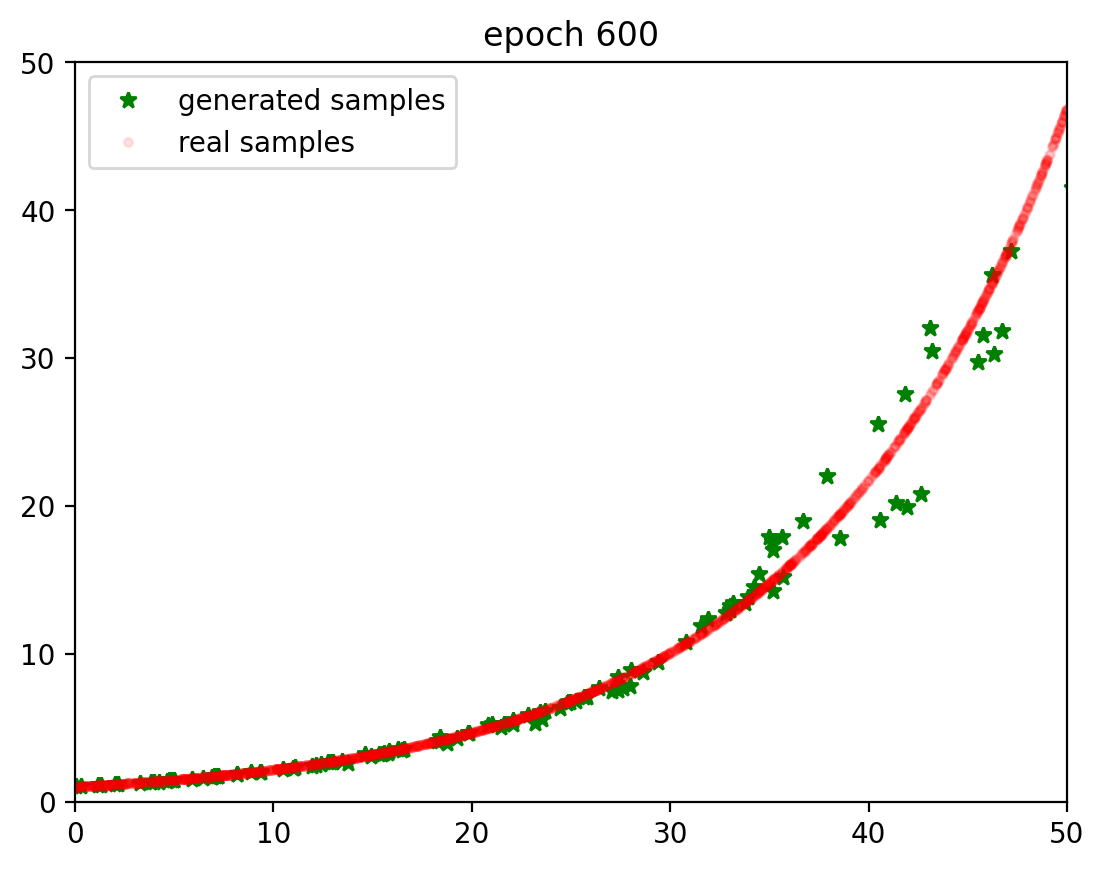

  6%|▌         | 624/10000 [01:56<26:17,  5.94it/s]

at epoch 625, G loss: 0.763746960957845, D loss 1.4746920267740886


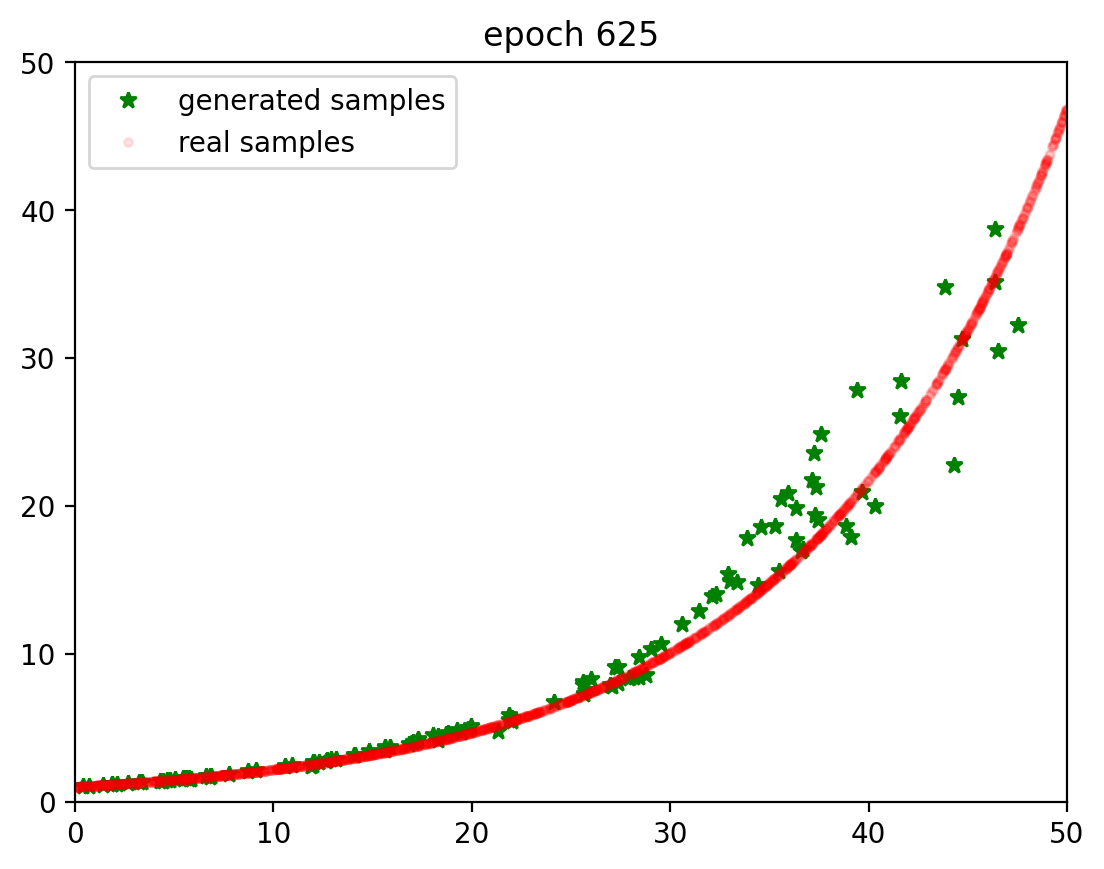

  6%|▋         | 649/10000 [02:01<28:24,  5.49it/s]

at epoch 650, G loss: 0.7483173370361328, D loss 1.469610087076823


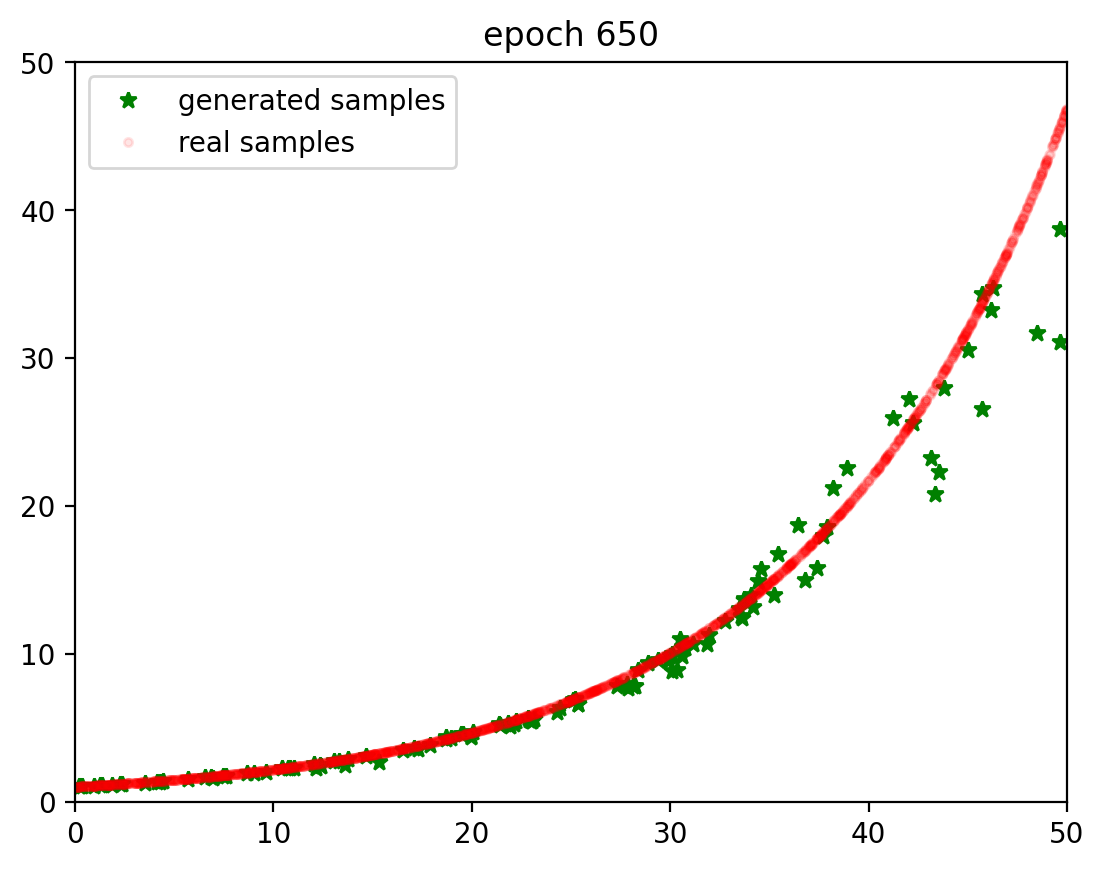

  7%|▋         | 674/10000 [02:05<27:27,  5.66it/s]

at epoch 675, G loss: 0.7587807337443034, D loss 1.4625011444091798


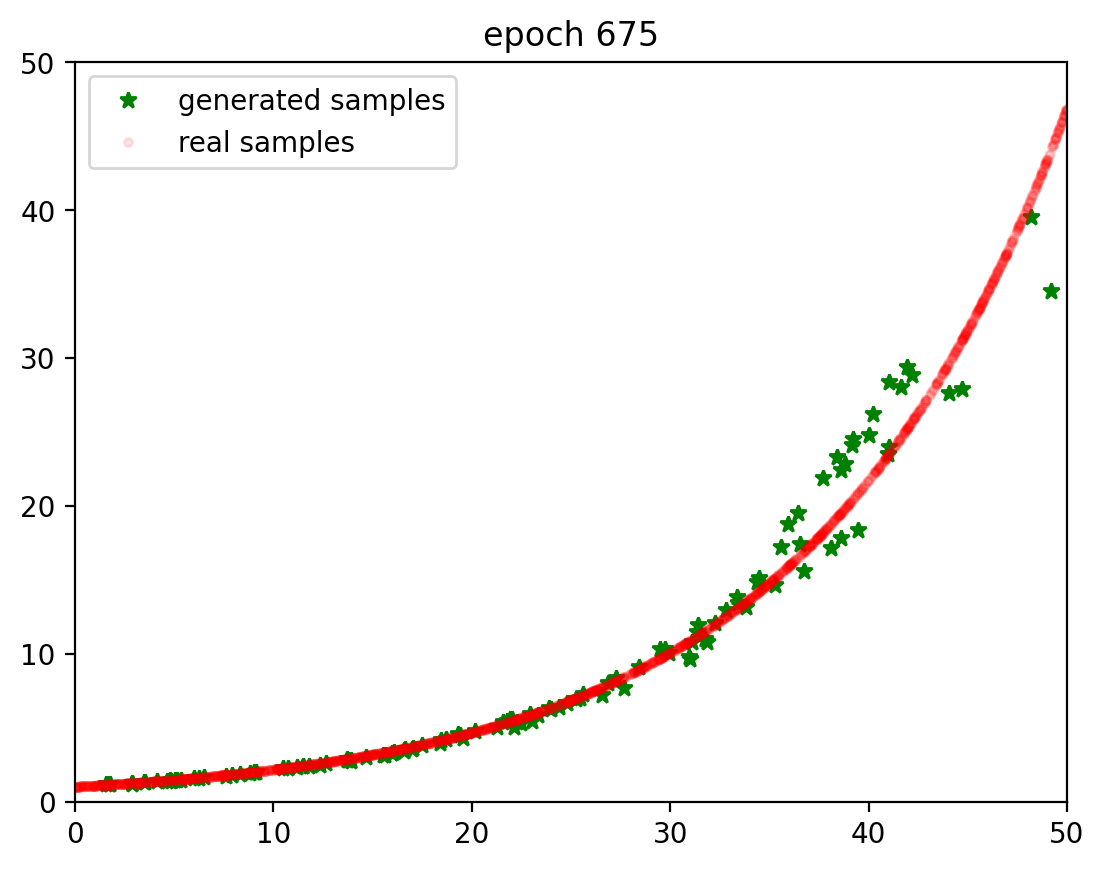

  7%|▋         | 699/10000 [02:10<25:26,  6.09it/s]

at epoch 700, G loss: 0.7658681233723958, D loss 1.4676934560139974


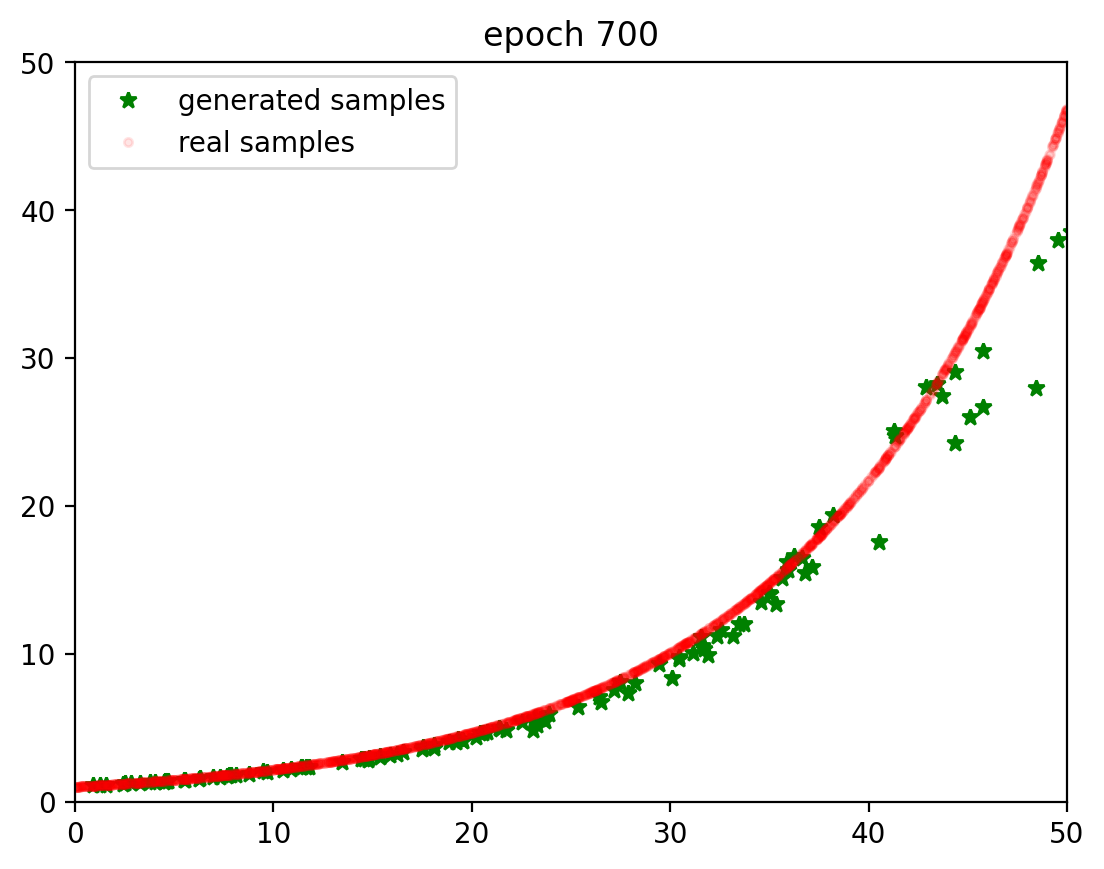

  7%|▋         | 724/10000 [02:15<25:34,  6.05it/s]

at epoch 725, G loss: 0.7602811177571615, D loss 1.4657801310221354


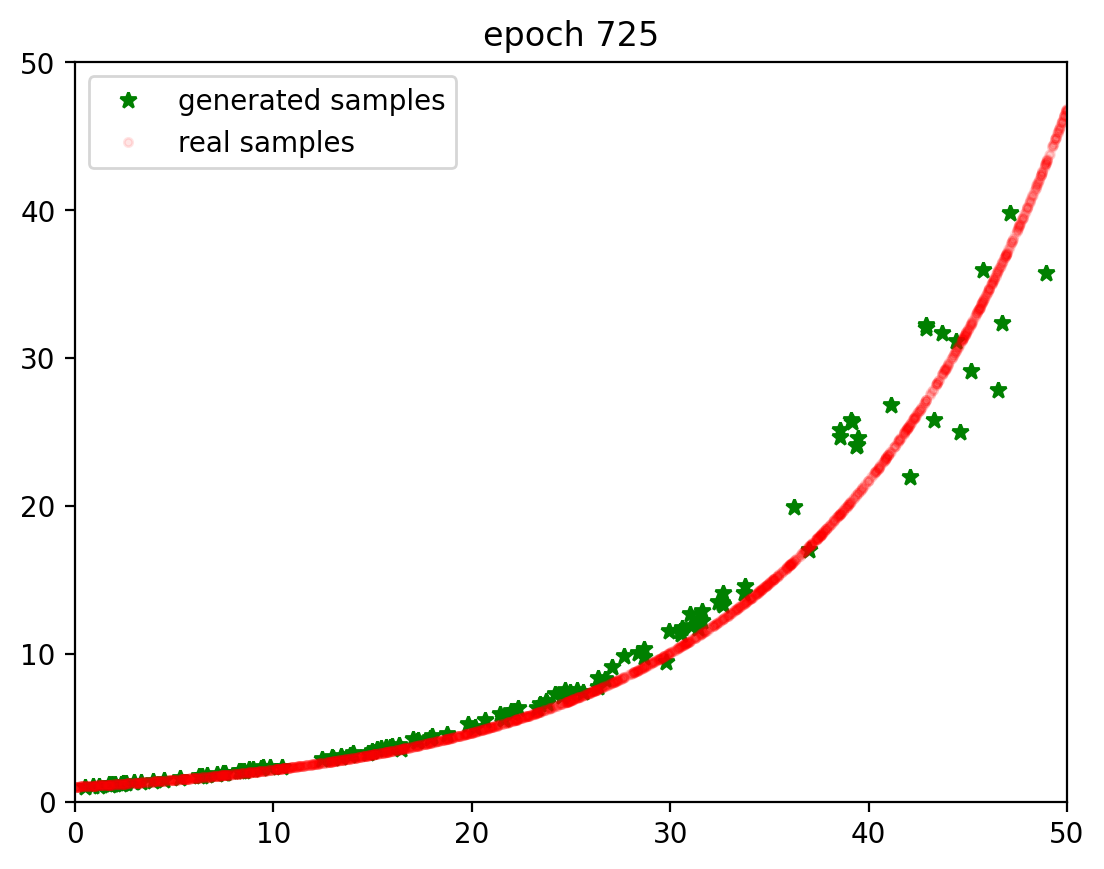

  7%|▋         | 749/10000 [02:19<25:16,  6.10it/s]

at epoch 750, G loss: 0.7720434188842773, D loss 1.4591107686360678


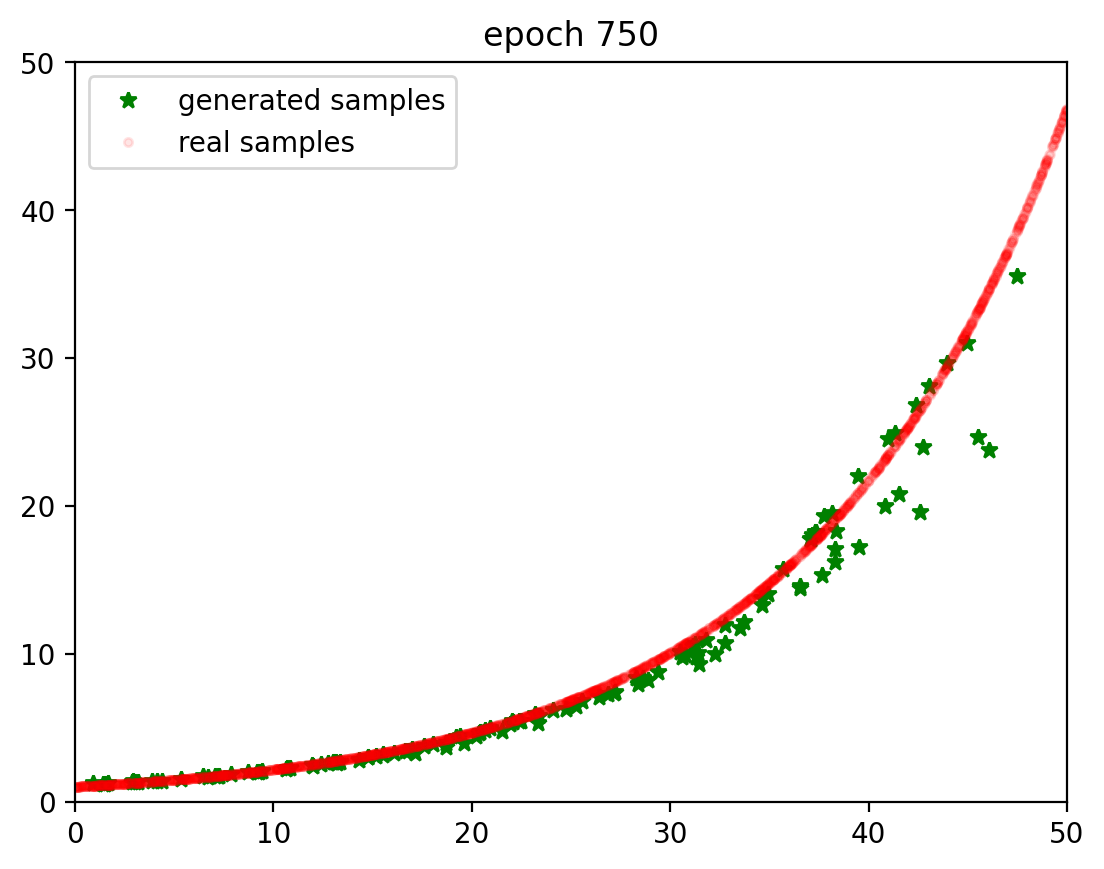

  8%|▊         | 774/10000 [02:24<25:15,  6.09it/s]

at epoch 775, G loss: 0.7716015497843425, D loss 1.4571725209554036


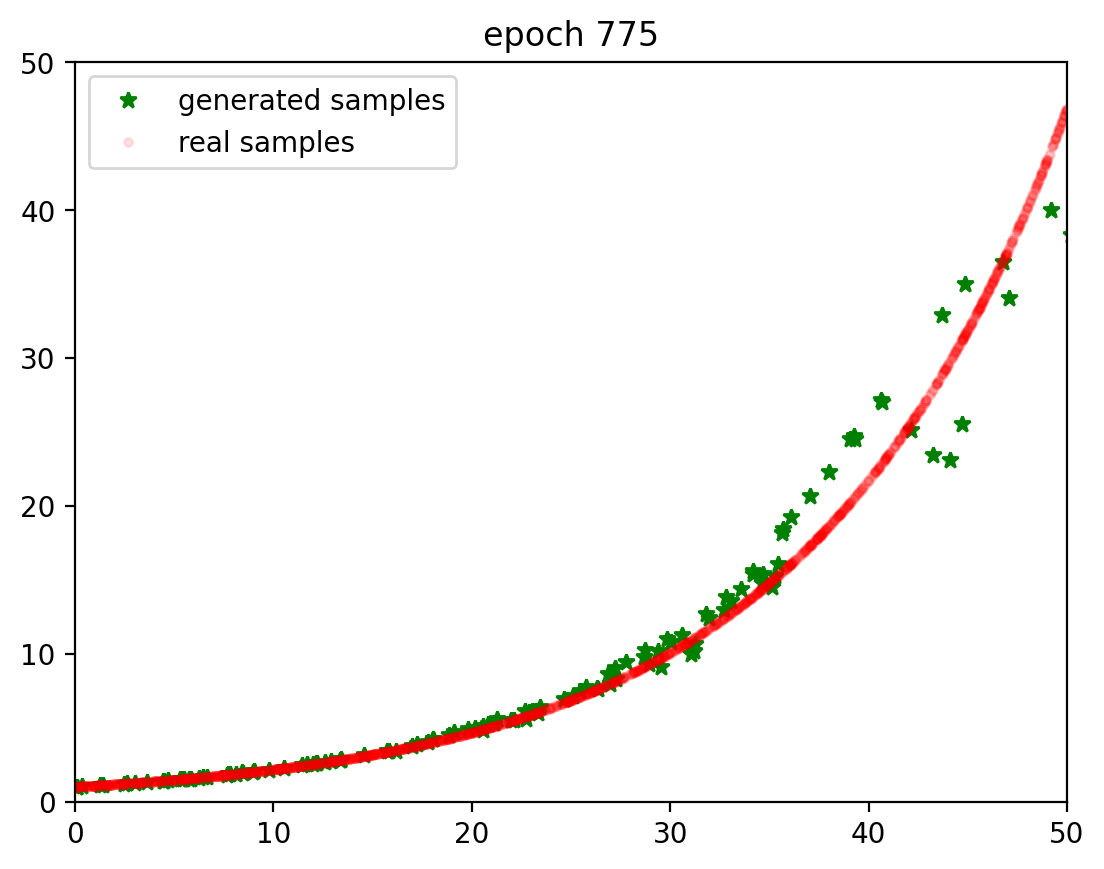

  8%|▊         | 799/10000 [02:29<25:05,  6.11it/s]

at epoch 800, G loss: 0.8043043772379558, D loss 1.4475140889485678


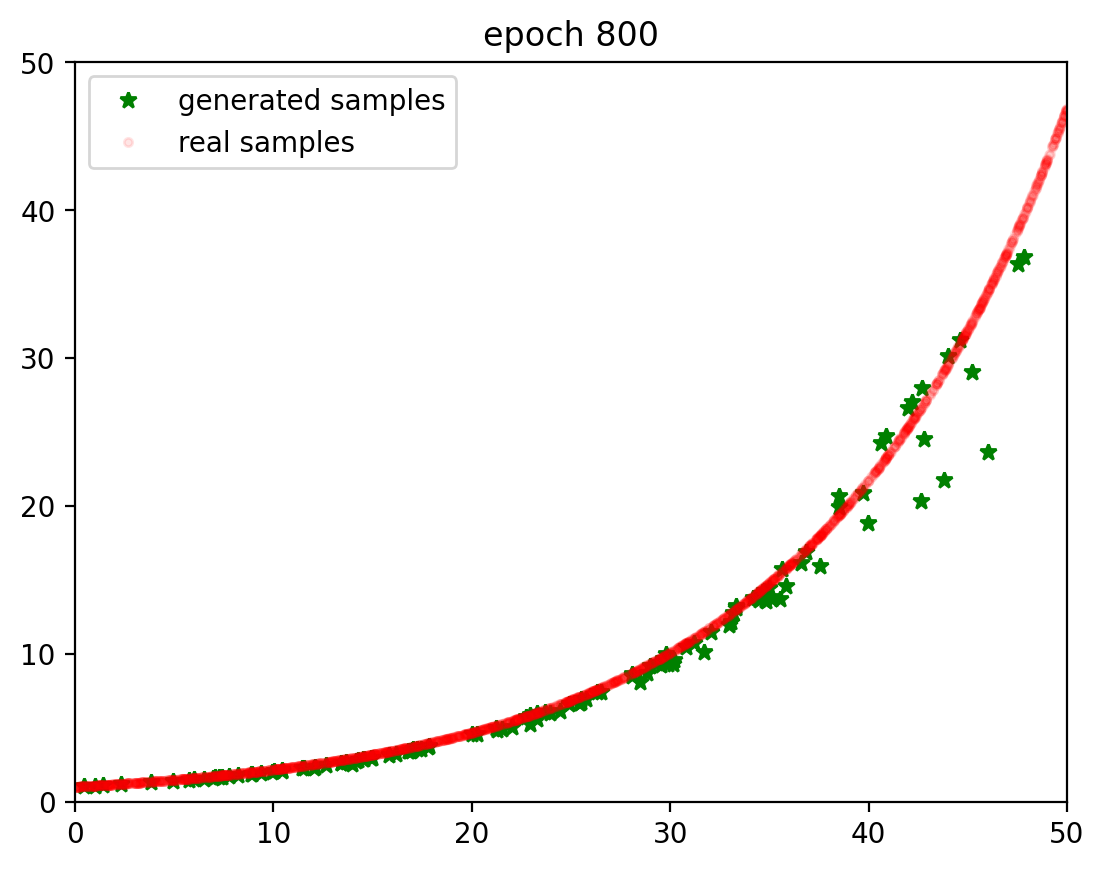

  8%|▊         | 824/10000 [02:34<24:52,  6.15it/s]

at epoch 825, G loss: 0.8043133417765299, D loss 1.445199966430664


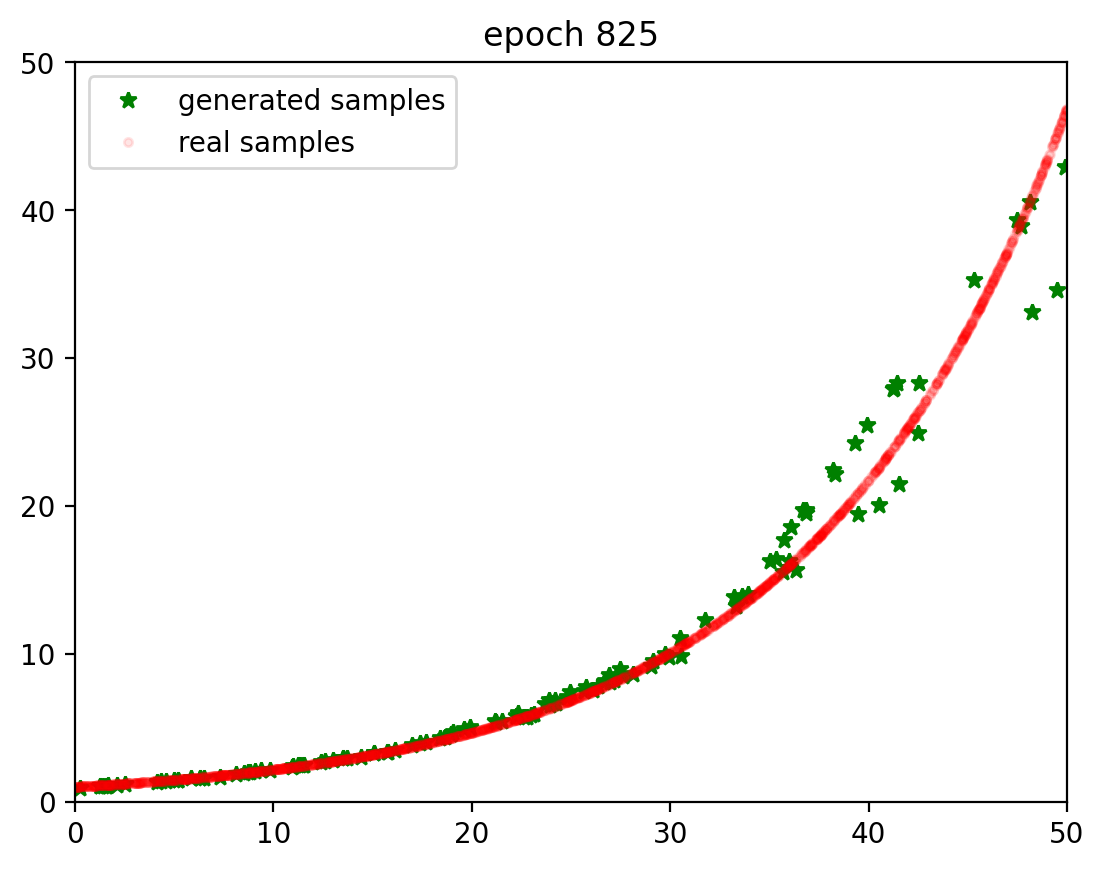

  8%|▊         | 849/10000 [02:38<24:49,  6.14it/s]

at epoch 850, G loss: 0.8282248179117838, D loss 1.456152852376302


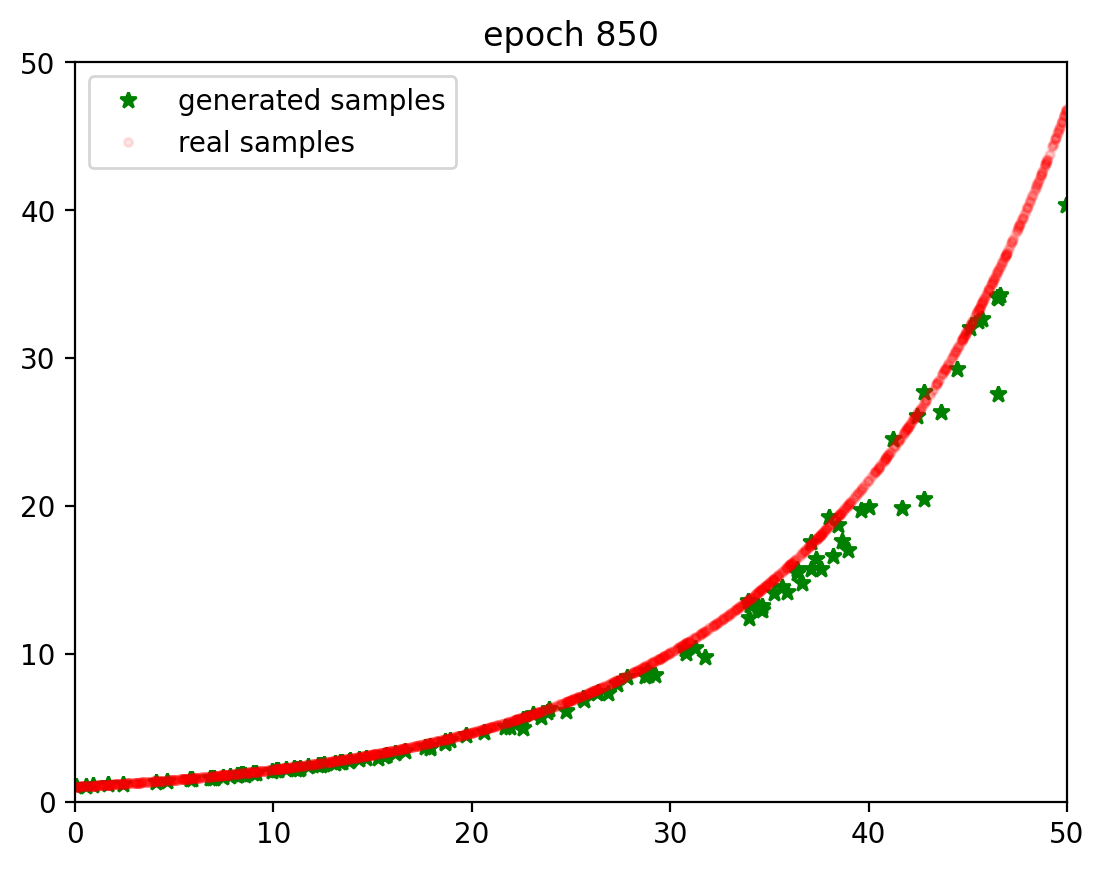

  9%|▊         | 874/10000 [02:43<24:59,  6.08it/s]

at epoch 875, G loss: 0.8343873977661133, D loss 1.4397440592447917


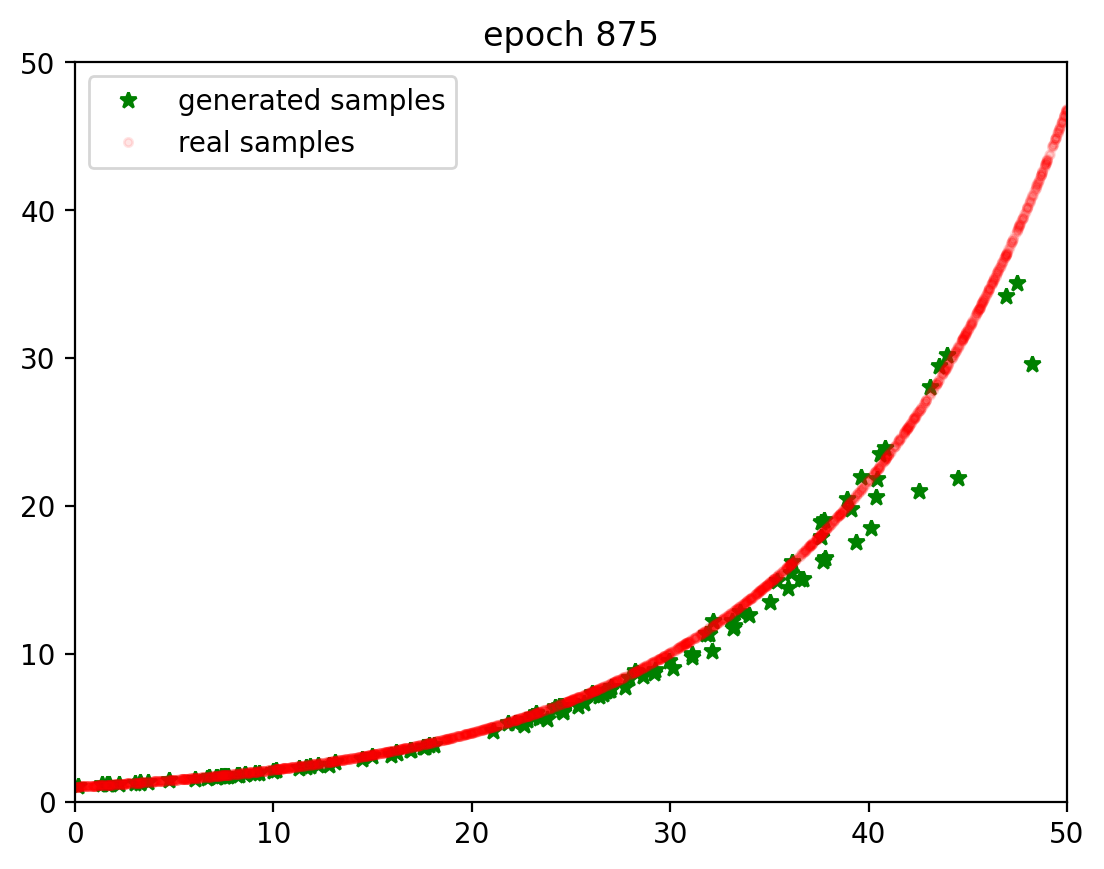

  9%|▉         | 899/10000 [02:48<24:47,  6.12it/s]

at epoch 900, G loss: 0.7880093256632487, D loss 1.445745849609375


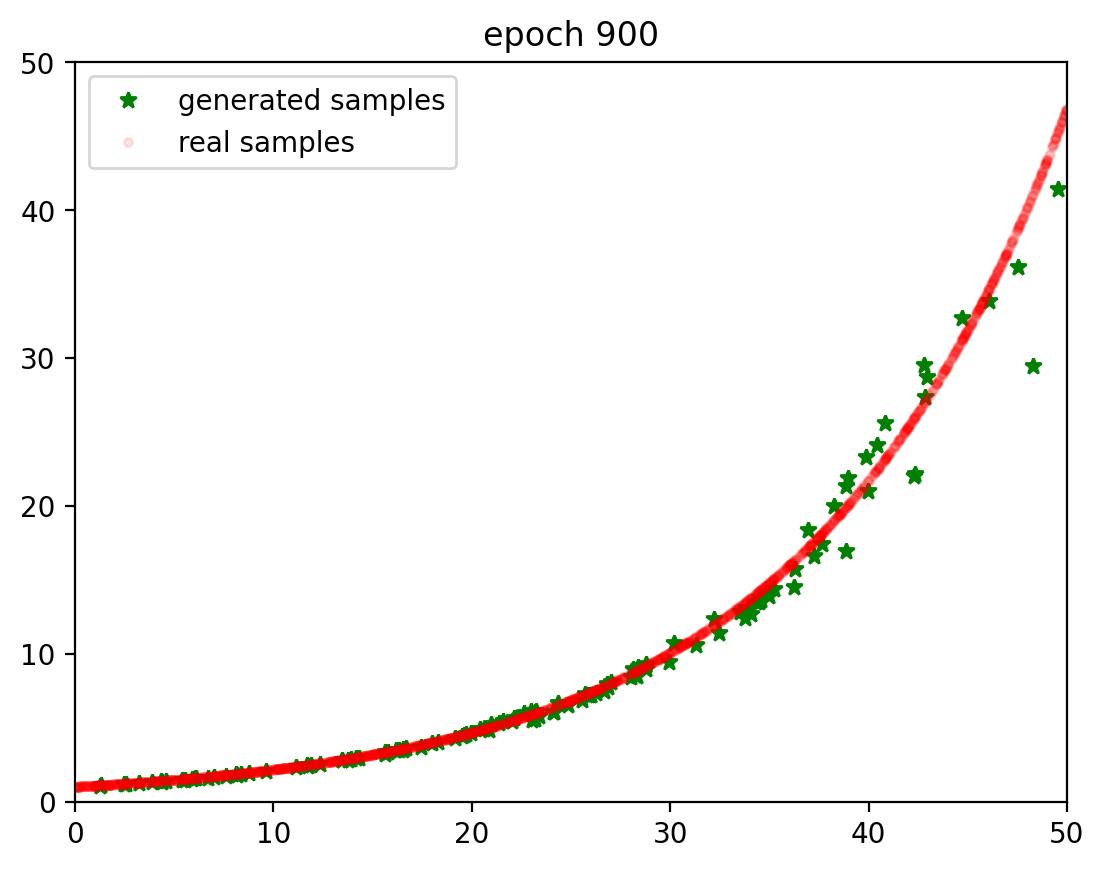

  9%|▉         | 924/10000 [02:52<25:23,  5.96it/s]

at epoch 925, G loss: 0.9100969314575196, D loss 1.4146714528401694


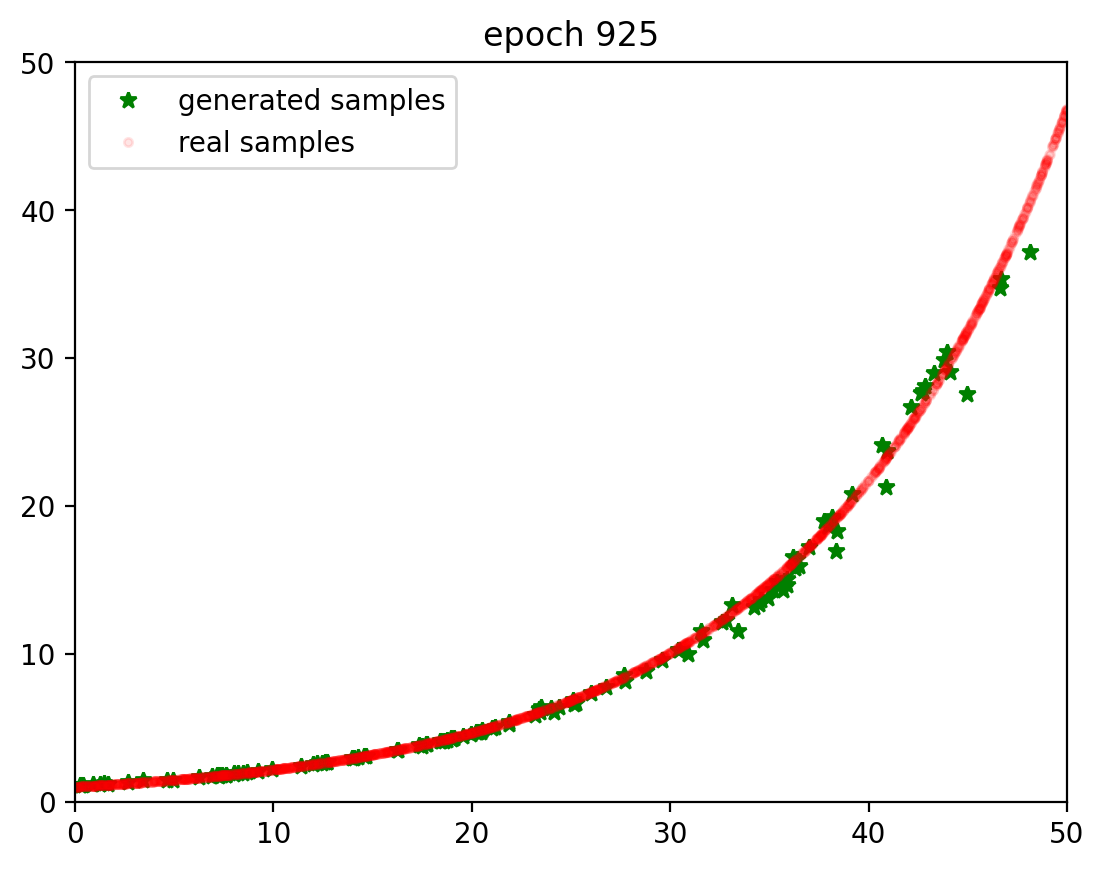

  9%|▉         | 949/10000 [02:57<25:37,  5.89it/s]

at epoch 950, G loss: 0.8129641850789388, D loss 1.4435831705729167


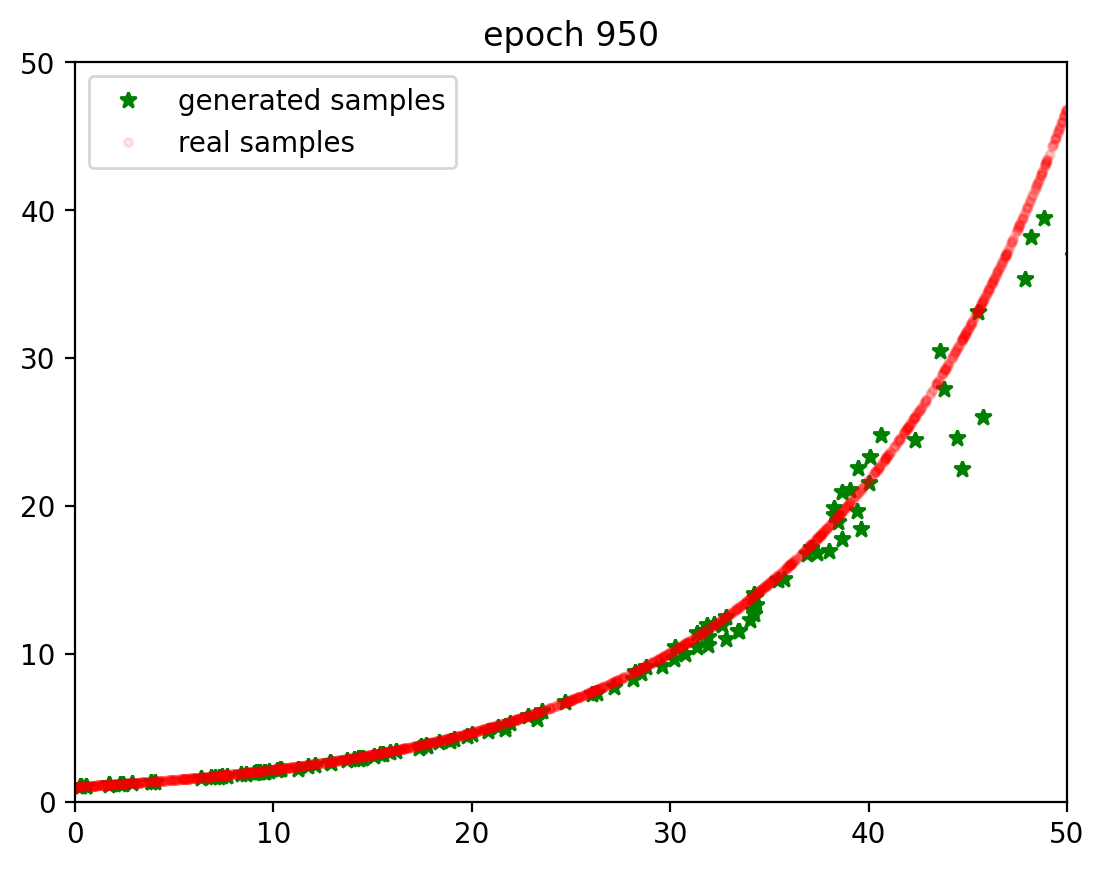

 10%|▉         | 974/10000 [03:02<25:31,  5.90it/s]

at epoch 975, G loss: 0.8132218678792318, D loss 1.4302318572998047


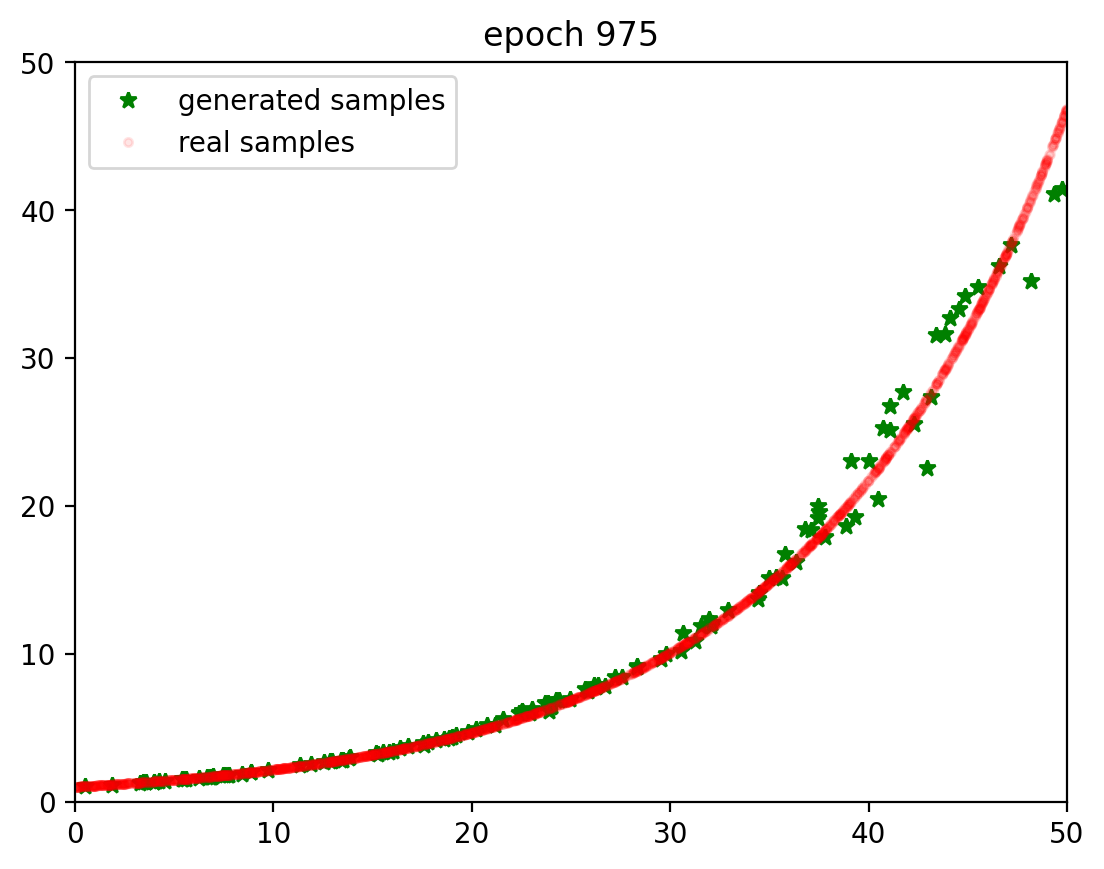

 10%|▉         | 999/10000 [03:06<25:29,  5.88it/s]

at epoch 1000, G loss: 0.8542086283365885, D loss 1.4303016662597656


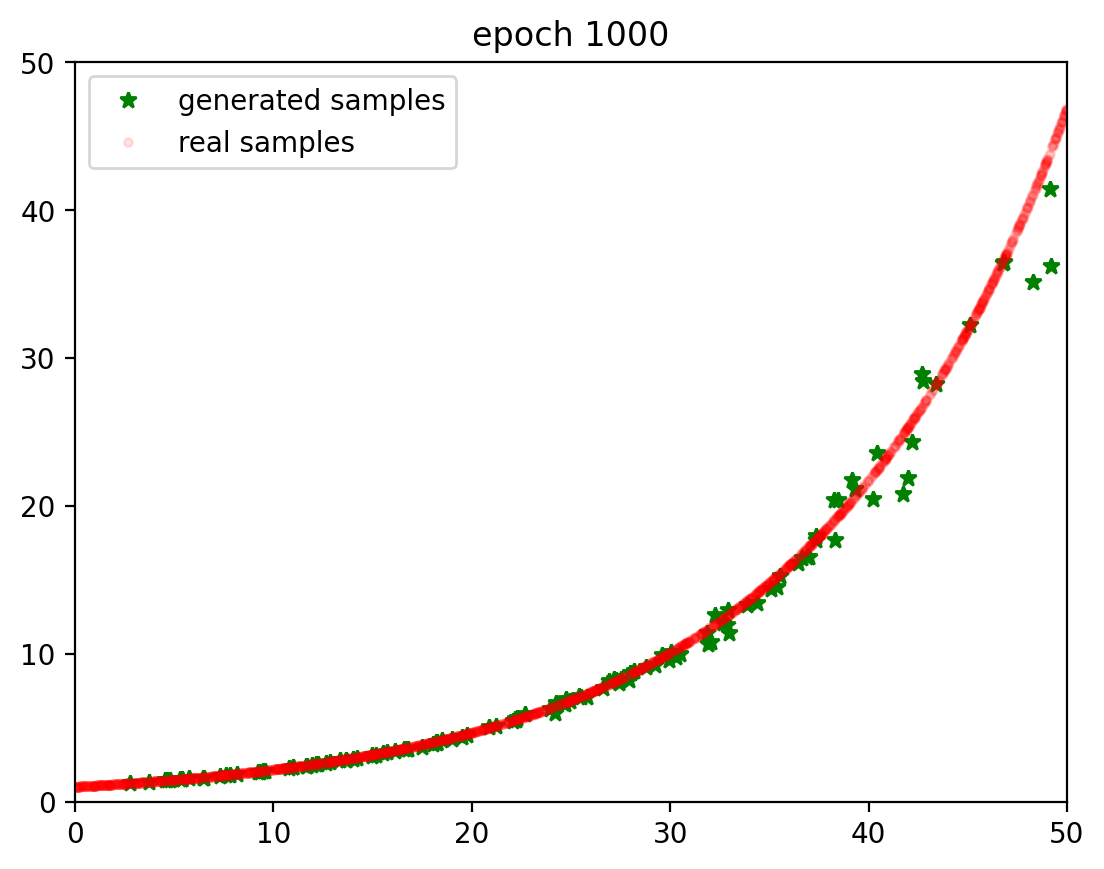

 10%|█         | 1024/10000 [03:11<25:22,  5.90it/s]

at epoch 1025, G loss: 0.8398296356201171, D loss 1.4094435373942058


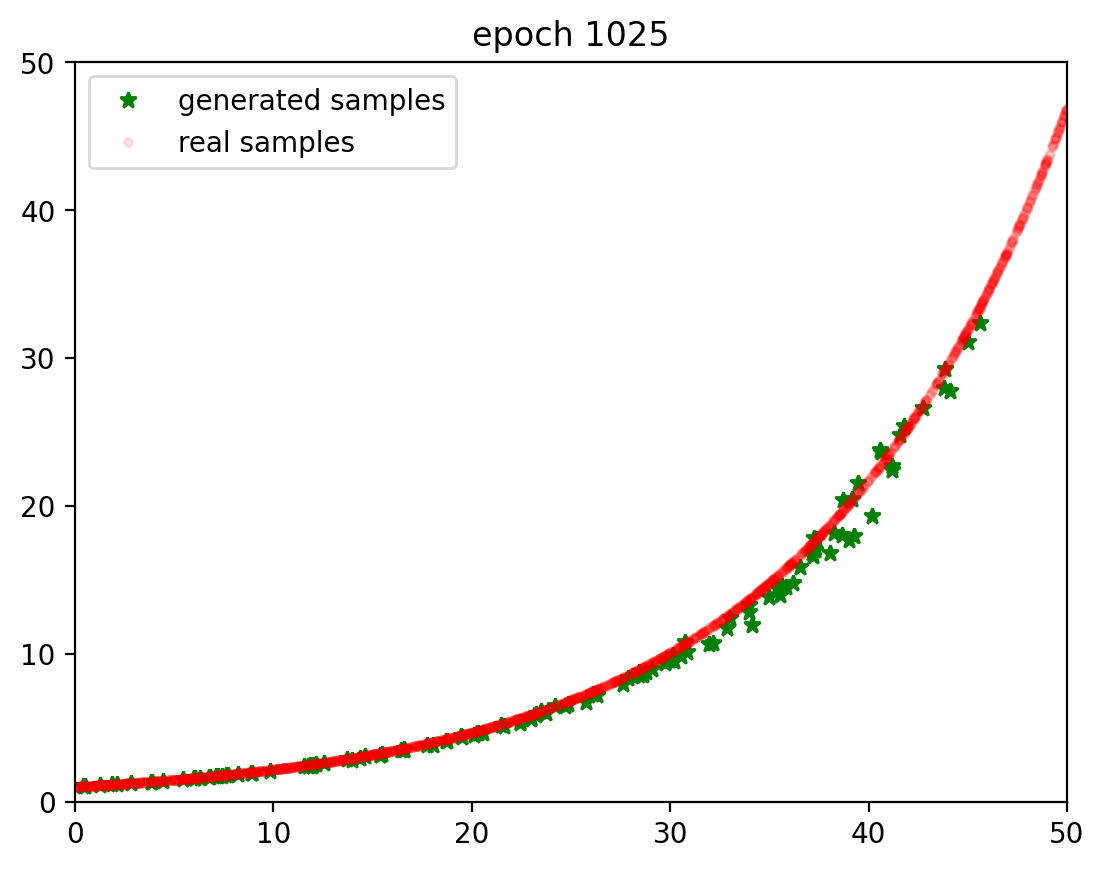

 10%|█         | 1036/10000 [03:14<28:02,  5.33it/s]


In [15]:
from tqdm import tqdm
for epoch in tqdm(range(10000)):    #A
    gloss=0
    dloss=0
    for n, real_samples in enumerate(train_loader):    #B
        loss_D=train_D_on_real(real_samples)
        dloss+=loss_D
        loss_D=train_D_on_fake()
        dloss+=loss_D
        loss_G,fake_samples=train_G()
        gloss+=loss_G
    test_epoch(epoch,gloss,dloss,n,fake_samples)    #C
    gdif=performance(fake_samples).item()
    if stopper.stop(gdif)==True:    #D
        break

In [16]:
import os
os.makedirs("files", exist_ok=True)
scripted = torch.jit.script(G) 
scripted.save('files/exponential.pt') 

In [17]:
new_G=torch.jit.load('files/exponential.pt',
                     map_location=device)
new_G.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
  (2): RecursiveScriptModule(original_name=Linear)
  (3): RecursiveScriptModule(original_name=ReLU)
  (4): RecursiveScriptModule(original_name=Linear)
)

In [18]:
noise=torch.randn((batch_size,2)).to(device)
new_data=new_G(noise)

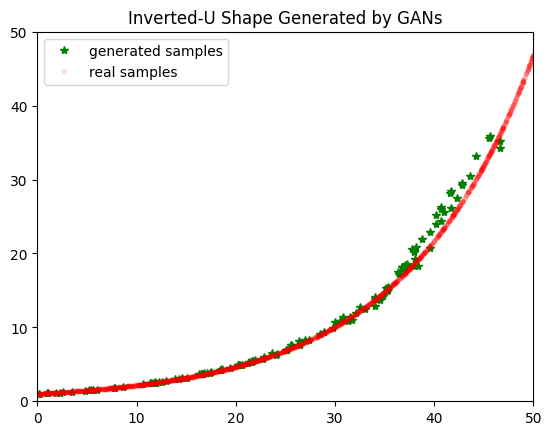

In [19]:
fig=plt.figure(dpi=100)
plt.plot(new_data.detach().cpu().numpy()[:,0],
  new_data.detach().cpu().numpy()[:,1],"*",c="g",
        label="generated samples")    #A
plt.plot(train_data[:,0],train_data[:,1],".",c="r",
         alpha=0.1,label="real samples")    #B
plt.title("Inverted-U Shape Generated by GANs")
plt.xlim(0,50)
plt.ylim(0,50)
plt.legend()
plt.show()

In [20]:
import torch

def onehot_encoder(position,depth):
    onehot=torch.zeros((depth,))
    onehot[position]=1
    return onehot

In [21]:
print(onehot_encoder(1,5))

tensor([0., 1., 0., 0., 0.])


In [22]:
def int_to_onehot(number):
    onehot=onehot_encoder(number,100)
    return onehot

In [23]:
onehot75=int_to_onehot(75)
print(onehot75)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [24]:
def onehot_to_int(onehot):
    num=torch.argmax(onehot)
    return num.item()

In [25]:
print(onehot_to_int(onehot75))

75


In [26]:
def gen_sequence():
    indices = torch.randint(0, 20, (10,))
    values = indices*5
    return values    

In [27]:
sequence=gen_sequence()
print(sequence)

tensor([35, 25, 95, 20, 15, 45, 60, 80, 55, 65])


In [28]:
import numpy as np

def gen_batch():
    sequence=gen_sequence()    #A
    batch=[int_to_onehot(i).numpy() for i in sequence]    #B
    batch=np.array(batch)
    return torch.tensor(batch)
batch=gen_batch()

In [29]:
def data_to_num(data):
    num=torch.argmax(data,dim=-1)    #A
    return num
numbers=data_to_num(batch)    

In [30]:
from torch import nn
D=nn.Sequential(
    nn.Linear(100,1),
    nn.Sigmoid()).to(device)

In [31]:
G=nn.Sequential(
    nn.Linear(100,100),
    nn.ReLU()).to(device)

In [32]:
loss_fn=nn.BCELoss()
lr=0.0005
optimD=torch.optim.Adam(D.parameters(),lr=lr)
optimG=torch.optim.Adam(G.parameters(),lr=lr)

In [33]:
real_labels=torch.ones((10,1)).to(device)
fake_labels=torch.zeros((10,1)).to(device)

In [34]:
def train_D_G(D,G,loss_fn,optimD,optimG):
    # Generate examples of real data
    true_data=gen_batch().to(device)
    # use 1 as labels since they are real
    preds=D(true_data)
    loss_D1=loss_fn(preds,real_labels.reshape(10,1))
    optimD.zero_grad()
    loss_D1.backward()
    optimD.step()
    # train D on fake data
    noise=torch.randn(10,100).to(device)
    generated_data=G(noise)
    # use 0 as labels since they are fake
    preds=D(generated_data)
    loss_D2=loss_fn(preds,fake_labels.reshape(10,1))
    optimD.zero_grad()
    loss_D2.backward()
    optimD.step()
    
    # train G 
    noise=torch.randn(10,100).to(device)
    generated_data=G(noise)
    # use 1 as labels since G wants to fool D
    preds=D(generated_data)
    loss_G=loss_fn(preds,real_labels.reshape(10,1))
    optimG.zero_grad()
    loss_G.backward()
    optimG.step()
    return generated_data       

In [35]:
stopper=EarlyStop(800)    #A

mse=nn.MSELoss()
real_labels=torch.ones((10,1)).to(device)
fake_labels=torch.zeros((10,1)).to(device)
def distance(generated_data):    #B
    nums=data_to_num(generated_data)
    remainders=nums%5
    ten_zeros=torch.zeros((10,1)).to(device)
    mseloss=mse(remainders,ten_zeros)
    return mseloss

for i in range(10000):
    gloss=0
    dloss=0
    generated_data=train_D_G(D,G,loss_fn,optimD,optimG)    #C  
    dis=distance(generated_data)
    if stopper.stop(dis)==True:
        break   
    if i % 50 == 0:
        print(data_to_num(generated_data))    #D

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([61, 12,  1, 94, 64, 23, 17, 86, 34,  1])
tensor([45, 63, 30, 10, 84, 24, 74, 45, 93, 58])
tensor([ 4, 20, 55, 99, 84, 69,  3, 22, 95, 31])
tensor([ 5, 63,  0, 99, 63, 67, 21, 41, 52, 69])
tensor([35, 52, 30, 31, 53,  5, 28, 99, 79, 33])
tensor([63, 95,  0, 95, 48, 83, 22, 12, 91, 54])
tensor([ 0, 95, 66, 38, 67,  3, 34, 66, 30, 13])
tensor([38,  0, 52, 95, 13,  2, 35, 48, 95,  0])
tensor([90, 35, 79, 99, 60, 67, 35, 84, 30, 95])
tensor([67, 99, 55, 53, 52, 66,  0,  0,  0, 95])
tensor([ 0, 95, 22,  0, 48, 95, 55, 22,  0, 84])
tensor([95, 95,  0, 35, 95, 48, 60,  0, 95, 48])
tensor([55, 22, 95, 99, 42, 50, 24, 95, 65, 60])
tensor([95, 10, 70,  5,  0, 50, 10,  0, 99, 95])
tensor([65, 21, 86, 95,  0, 10, 95, 95, 95,  0])
tensor([10, 25, 10, 65, 95, 10, 95, 80, 10,  0])
tensor([10, 10, 40,  0, 10, 85, 65, 65, 10,  0])
tensor([65, 65, 45, 10, 40, 10, 15, 40, 40,  0])
tensor([10, 40, 65, 10, 85, 65, 10, 65, 10, 69])
tensor([10, 65, 10, 50, 65, 40, 60, 40, 10, 65])
tensor([40, 40, 65, 

In [36]:
# Export to TorchScript
import os
os.makedirs("files", exist_ok=True)
scripted = torch.jit.script(G) 
scripted.save('files/num_gen.pt') 

In [37]:
new_G=torch.jit.load('files/num_gen.pt',
                     map_location=device)
new_G.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
)

In [38]:
# obtain inputs from the latent space
torch.manual_seed(42)
noise=torch.randn((10,100)).to(device)
# feed the input to the generator 
new_data=new_G(noise) 
print(data_to_num(new_data))

tensor([90, 45, 90, 25, 50, 50, 70, 45, 45, 45])


In [39]:
# exercise 3.1
import torch

torch.manual_seed(0)    
observations = 2048
train_data = torch.zeros((observations, 2))    
train_data[:,0]=10*(torch.rand(observations)-0.5)  
train_data[:,1]=torch.sin(train_data[:,0])  

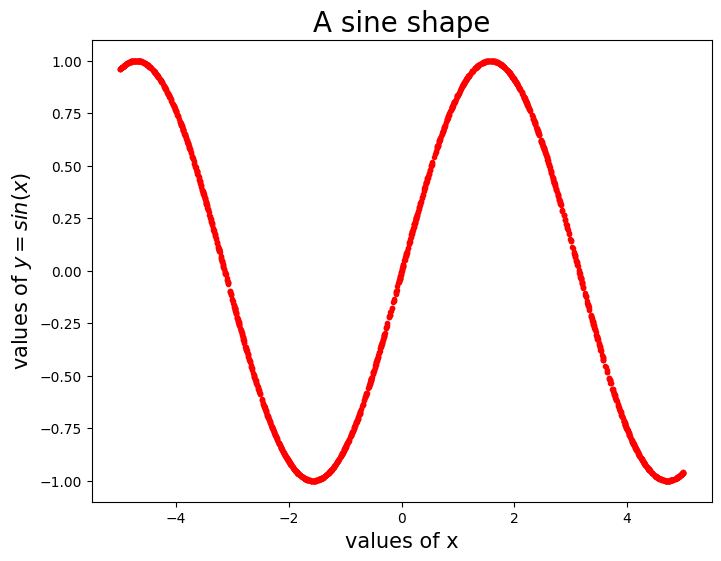

In [40]:
# exercise 3.2
import matplotlib.pyplot as plt

fig=plt.figure(dpi=100,figsize=(8,6))
plt.plot(train_data[:,0],train_data[:,1],".",c="r")
plt.xlabel("values of x",fontsize=15)
plt.ylabel("values of $y=sin(x)$",fontsize=15)
plt.title("A sine shape",fontsize=20)
plt.show()

  0%|          | 0/300 [00:00<?, ?it/s]

at epoch 0, G loss: 0.7194144956527218, D loss 1.0105950755457724


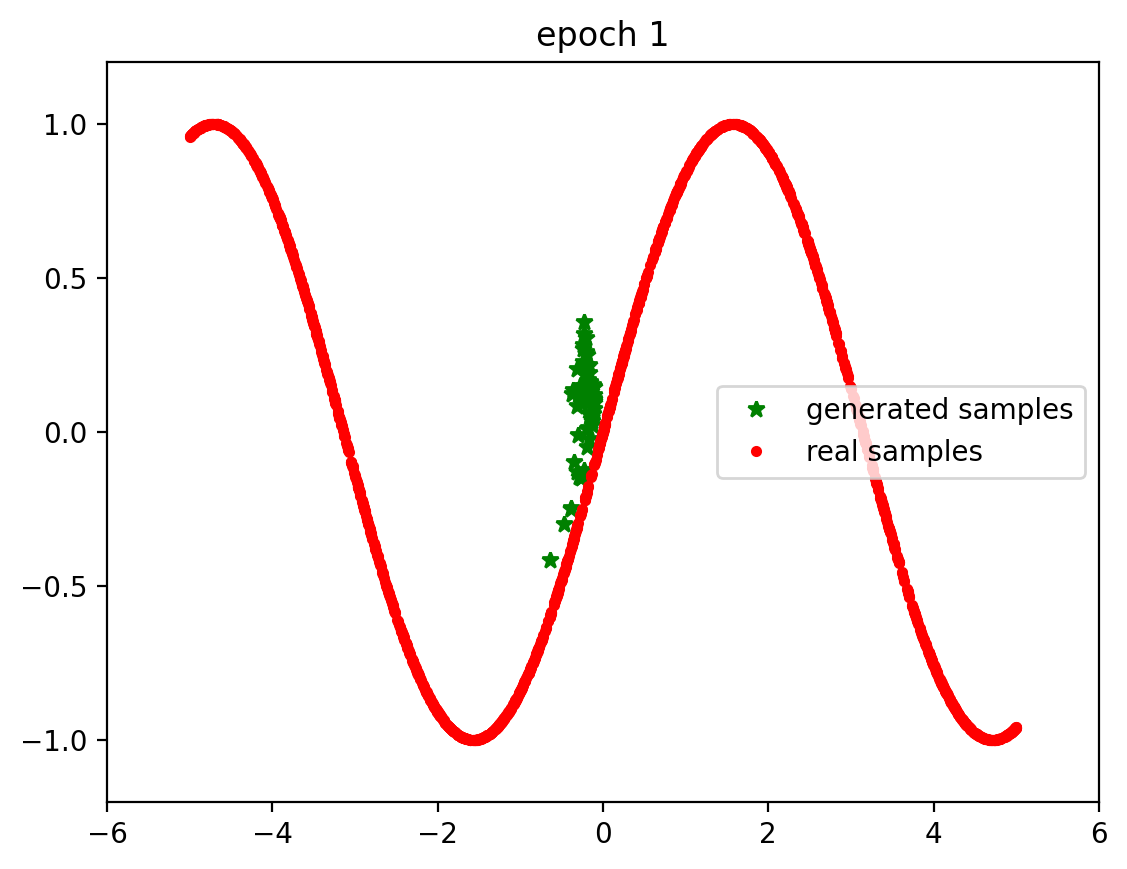

  8%|▊         | 24/300 [00:06<01:09,  3.99it/s]

at epoch 24, G loss: 1.096651384907384, D loss 1.1453055104901713


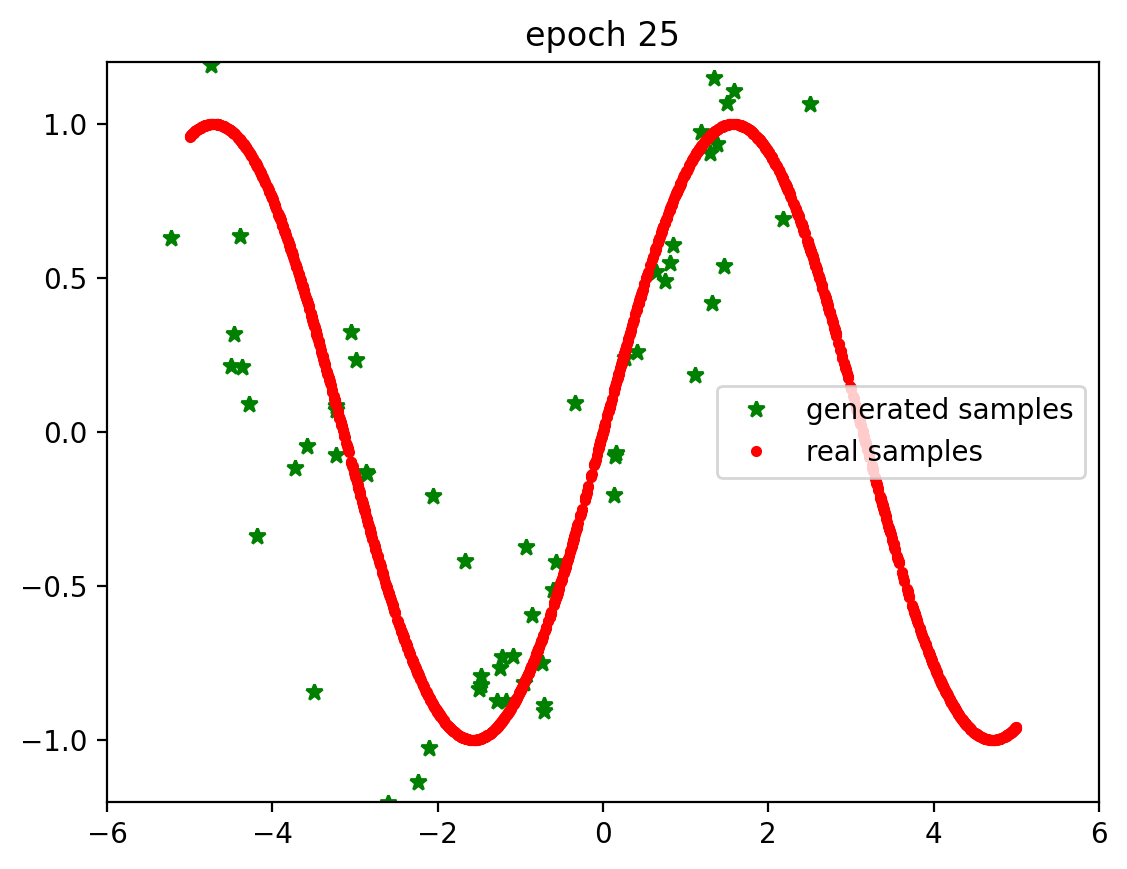

 16%|█▋        | 49/300 [00:13<01:05,  3.81it/s]

at epoch 49, G loss: 0.8969387546662362, D loss 1.2160544856902091


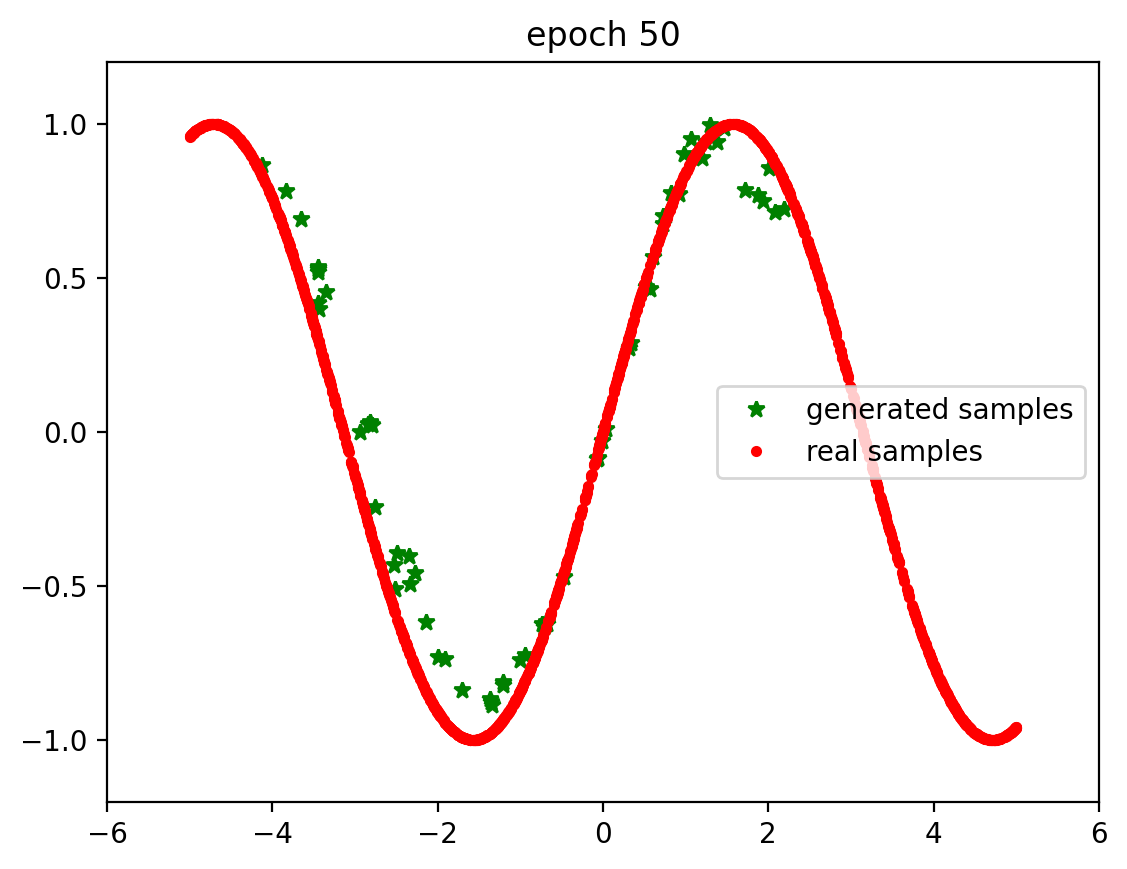

 25%|██▍       | 74/300 [00:20<01:00,  3.74it/s]

at epoch 74, G loss: 0.7729165477137412, D loss 1.397976290795111


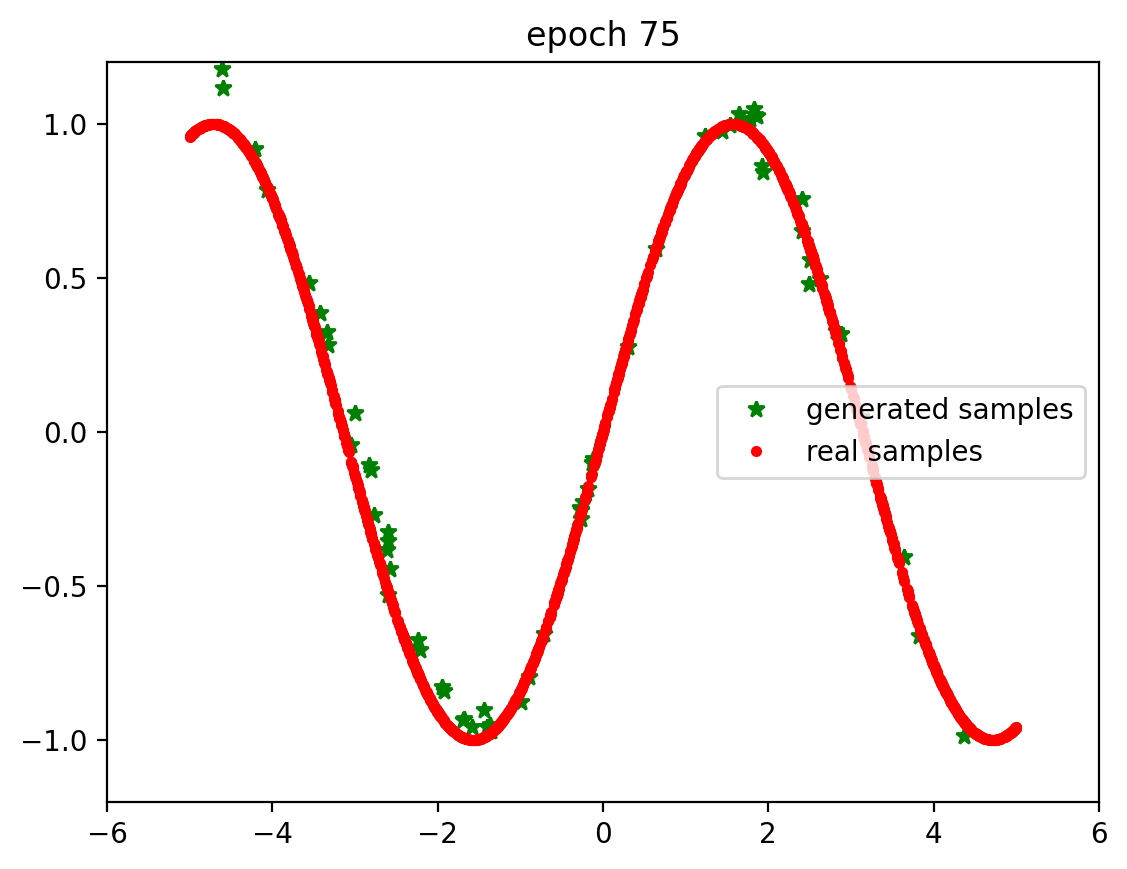

 33%|███▎      | 99/300 [00:27<00:56,  3.59it/s]

at epoch 99, G loss: 0.7878972945674774, D loss 1.3858146667480469


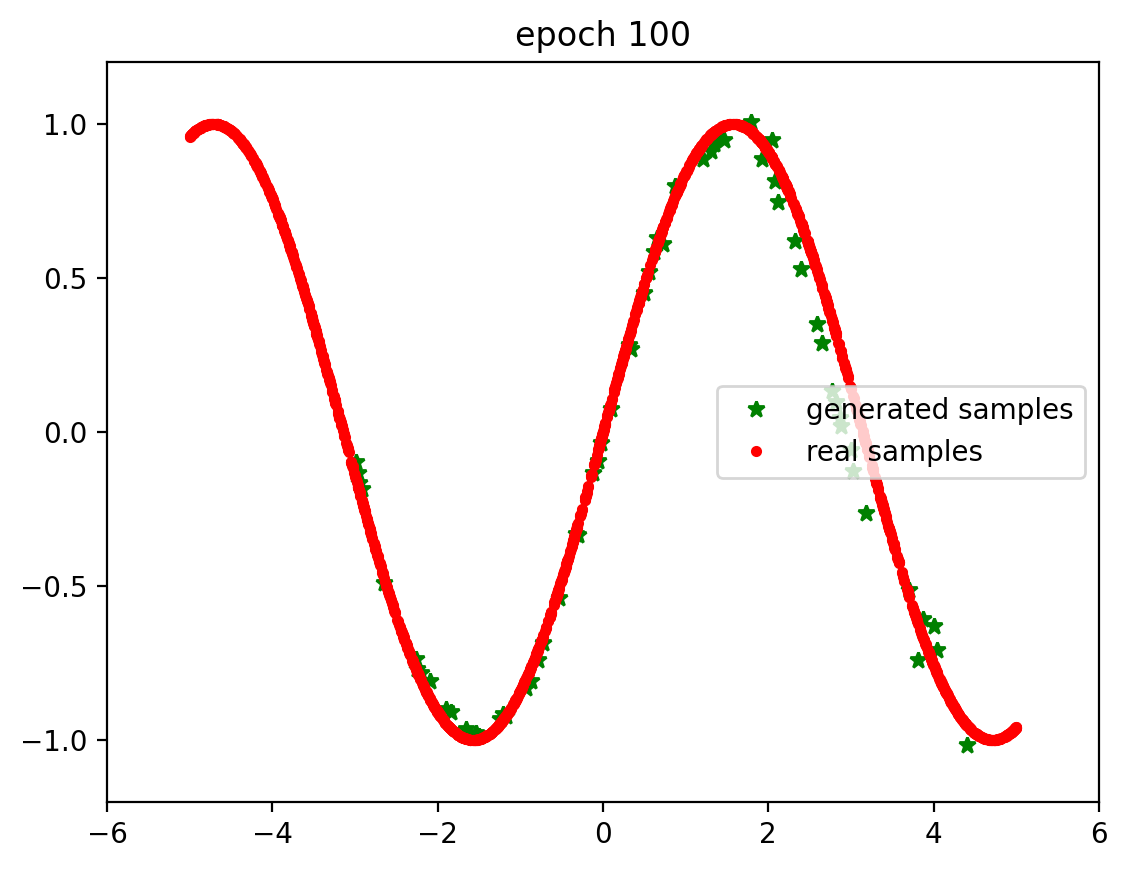

 41%|████▏     | 124/300 [00:34<00:47,  3.73it/s]

at epoch 124, G loss: 0.7784782532722719, D loss 1.3796151684176536


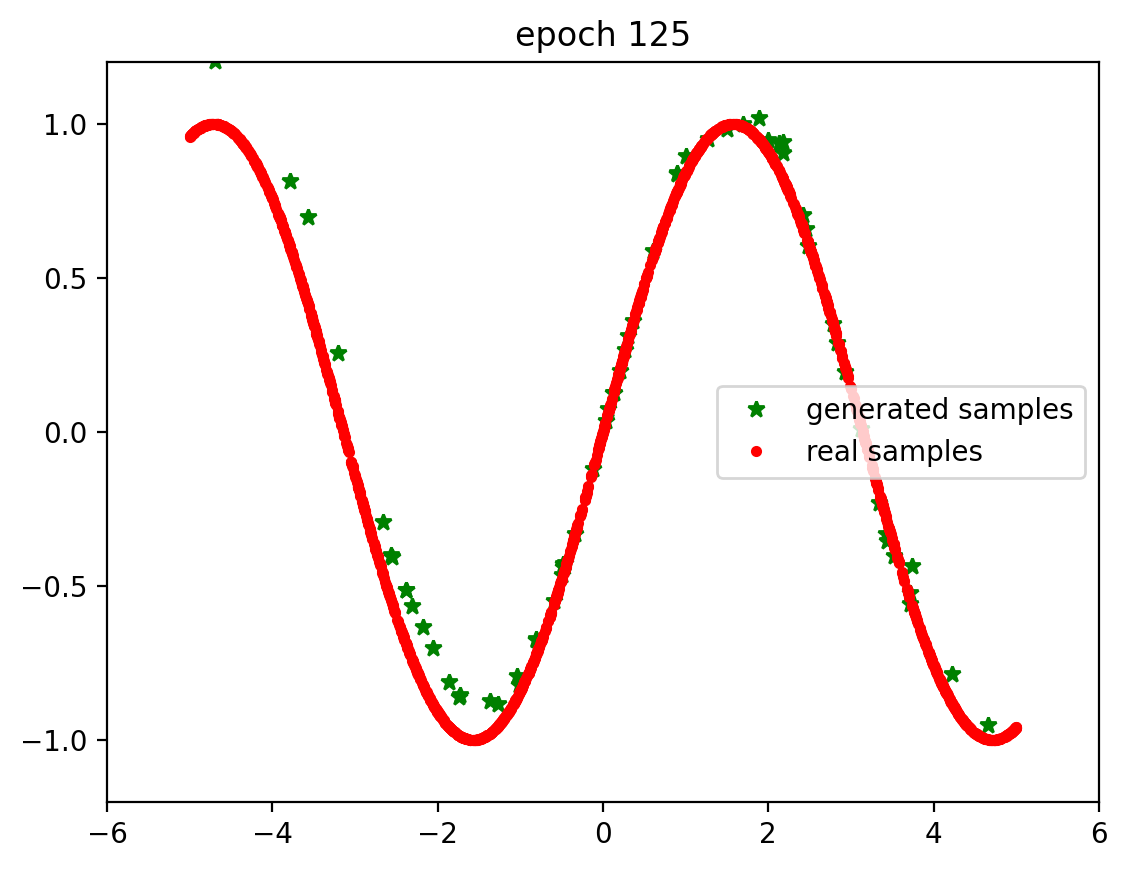

 50%|████▉     | 149/300 [00:41<00:41,  3.68it/s]

at epoch 149, G loss: 0.7706333898728893, D loss 1.4037367297757057


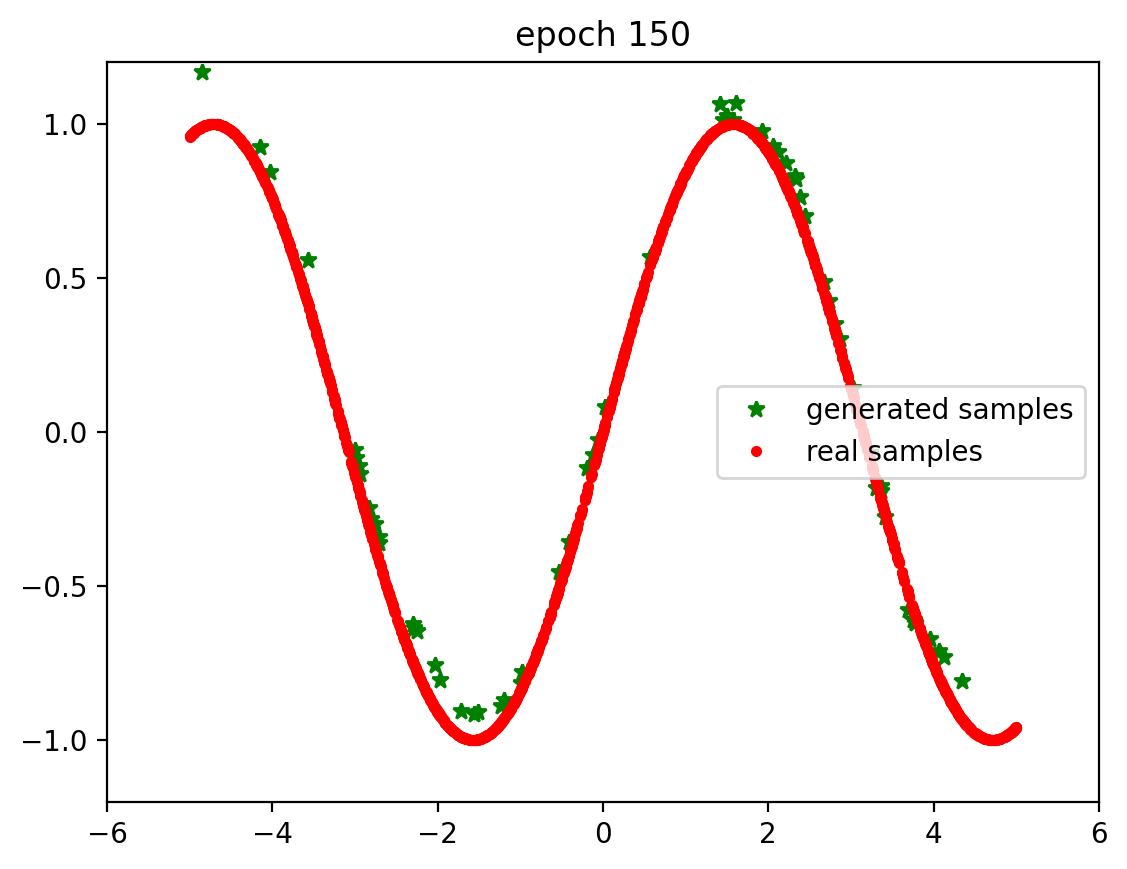

 58%|█████▊    | 174/300 [00:48<00:35,  3.58it/s]

at epoch 174, G loss: 0.748259021389869, D loss 1.3955320542858494


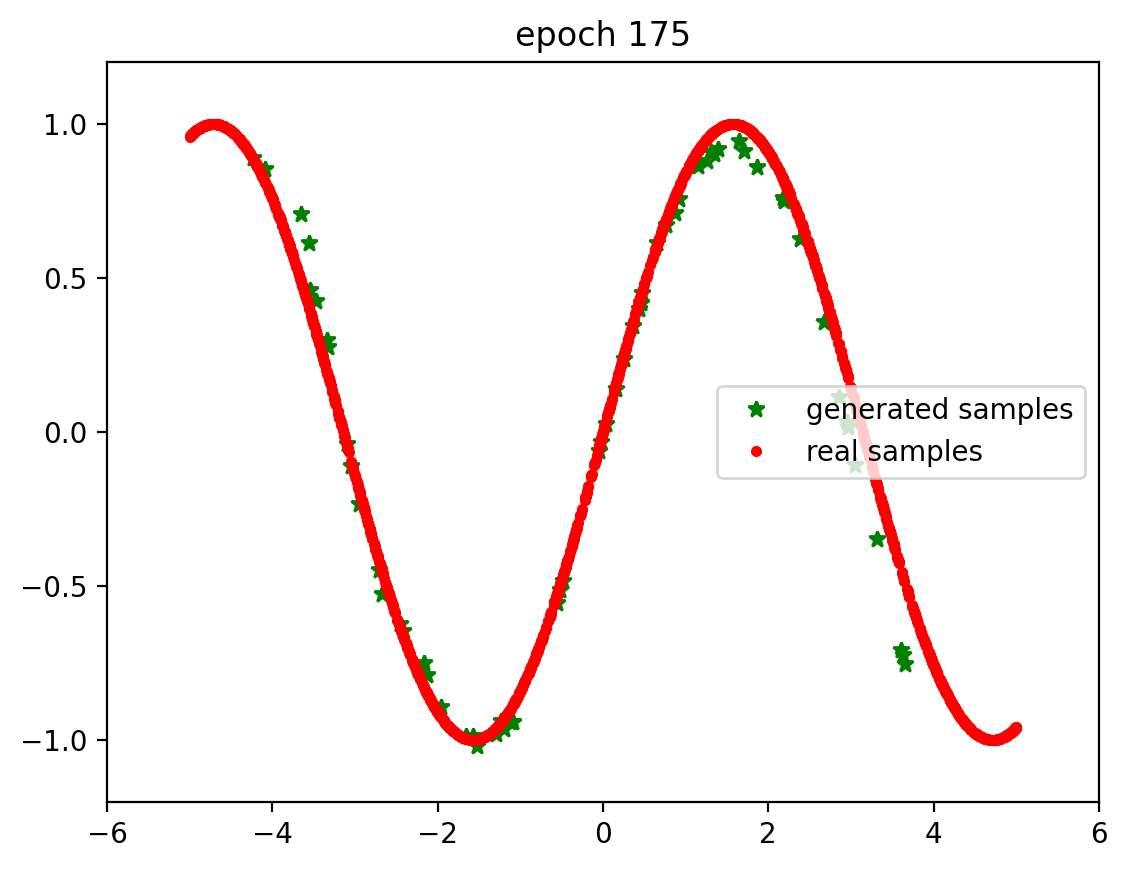

 66%|██████▋   | 199/300 [00:56<00:27,  3.62it/s]

at epoch 199, G loss: 0.7402468650571762, D loss 1.413241970923639


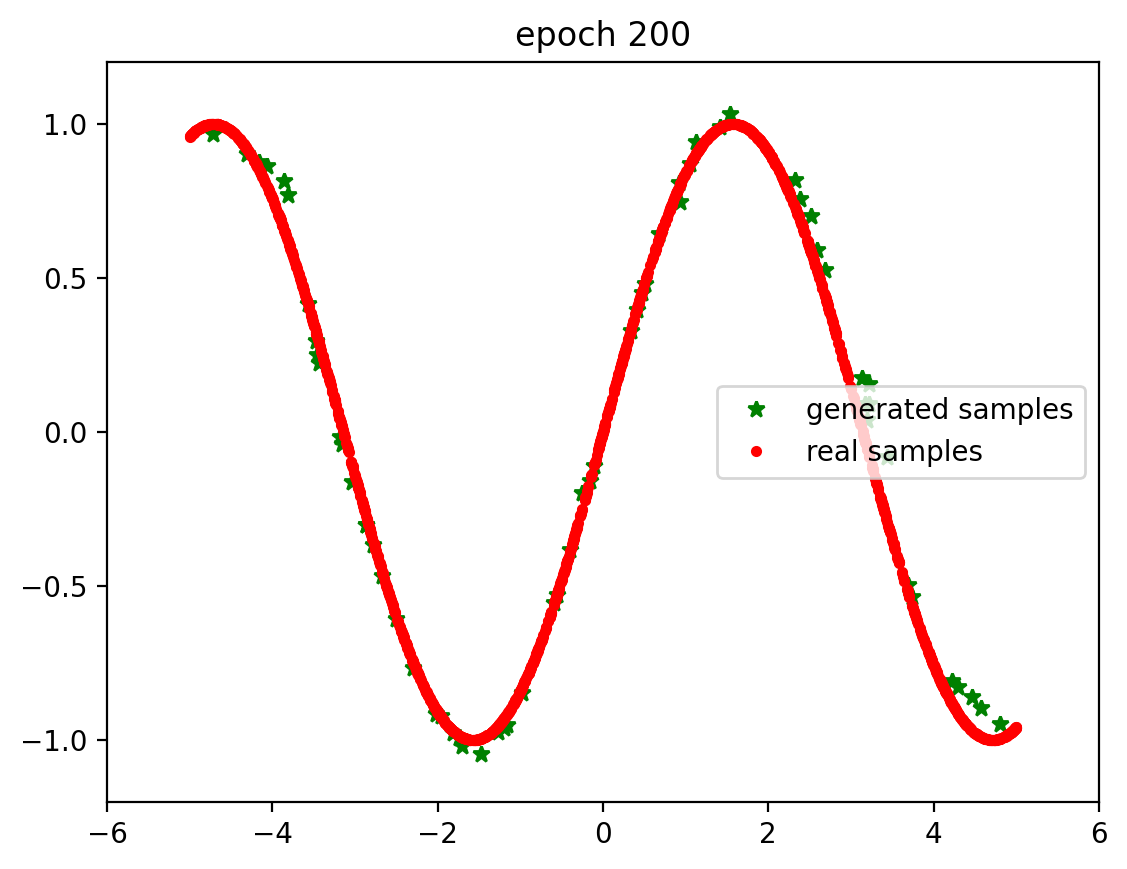

 75%|███████▍  | 224/300 [01:04<00:22,  3.31it/s]

at epoch 224, G loss: 0.7444225434334047, D loss 1.4167525999007686


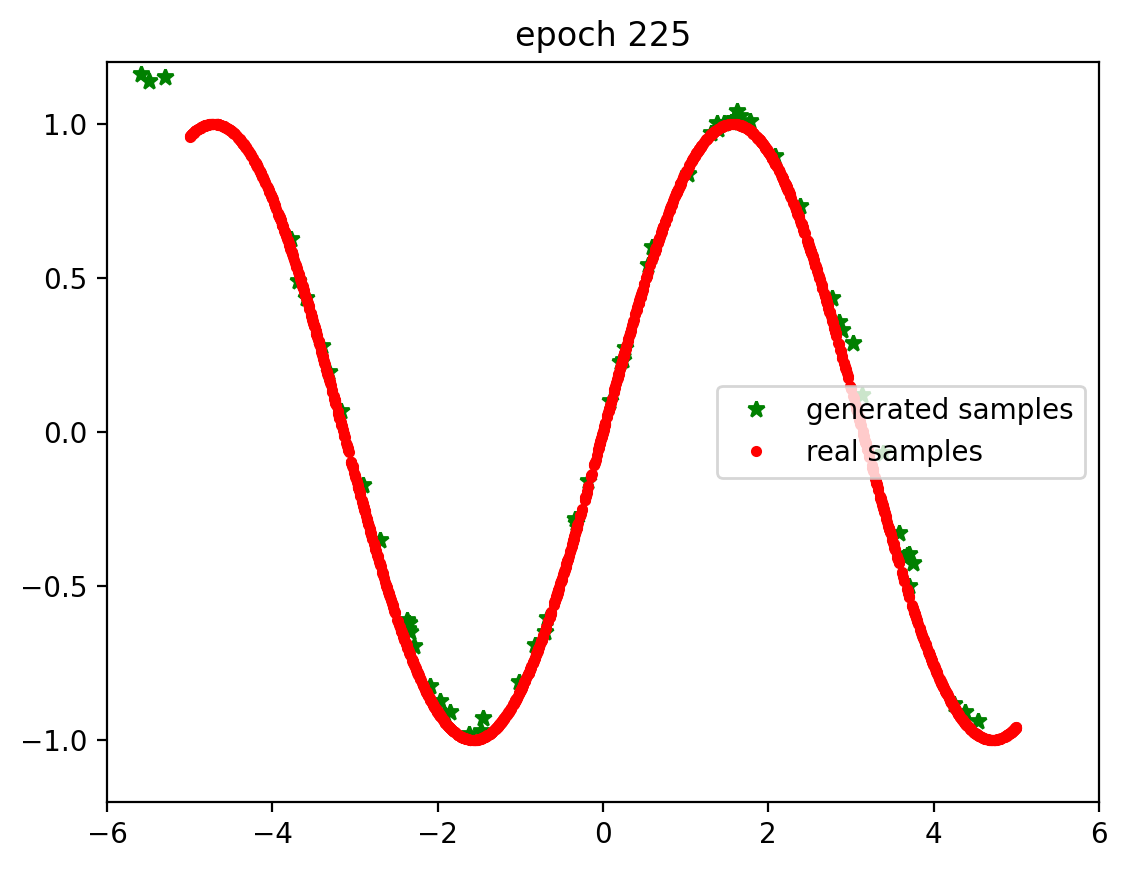

 83%|████████▎ | 249/300 [01:11<00:14,  3.49it/s]

at epoch 249, G loss: 0.7368732575447329, D loss 1.424344216623614


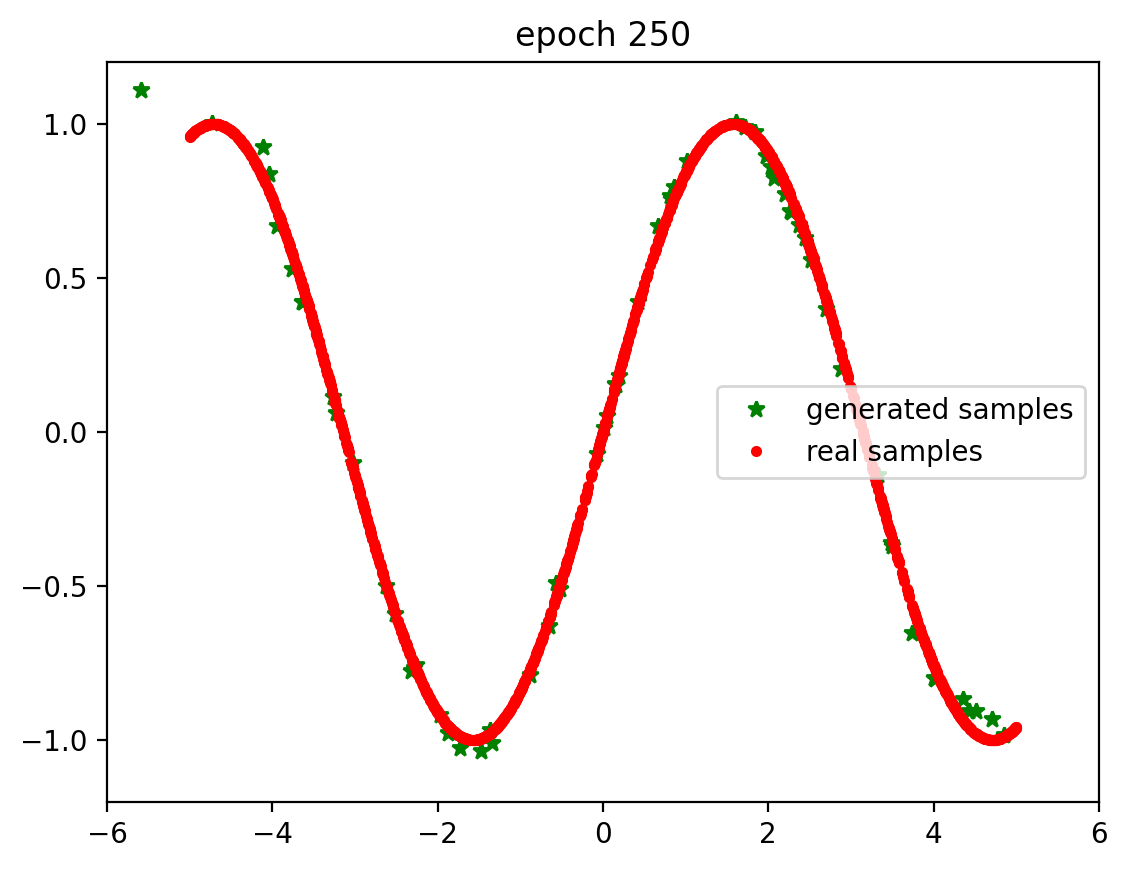

 91%|█████████▏| 274/300 [01:18<00:07,  3.42it/s]

at epoch 274, G loss: 0.7241886508080267, D loss 1.4269180297851562


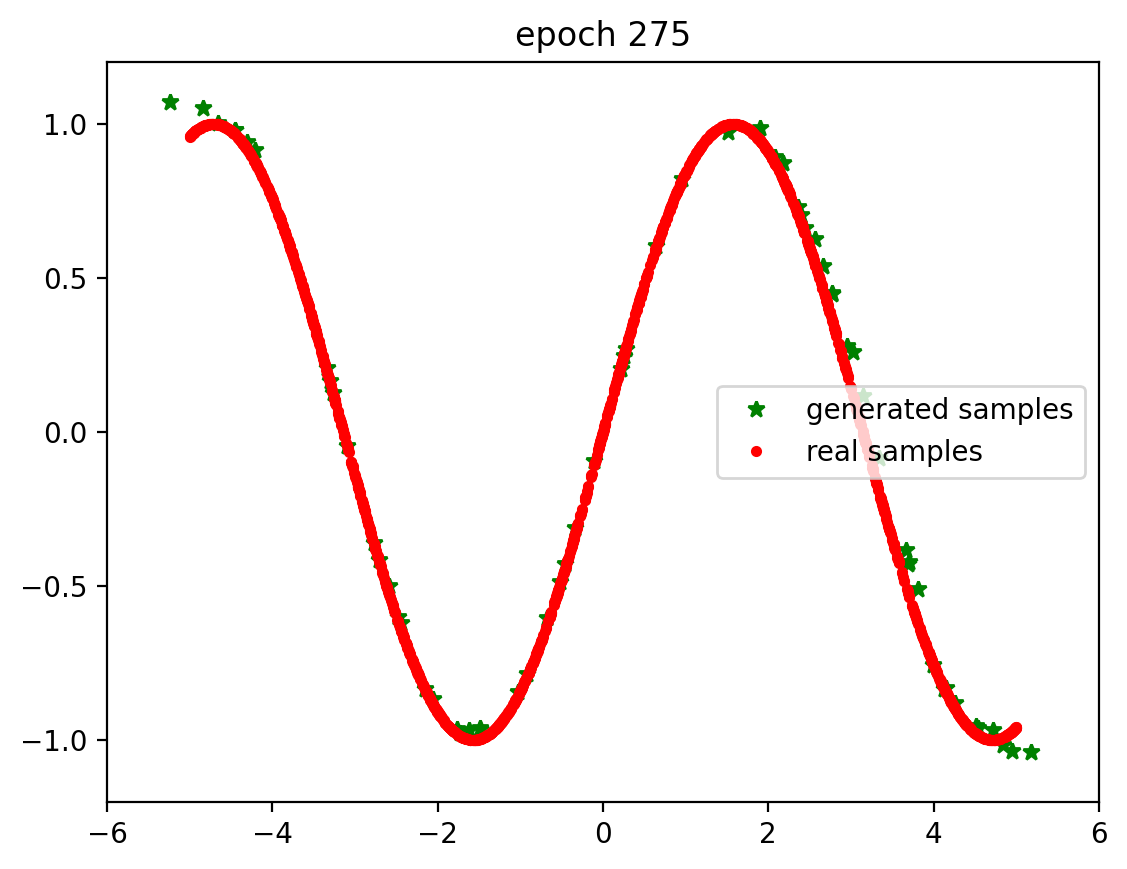

100%|█████████▉| 299/300 [01:26<00:00,  3.53it/s]

at epoch 299, G loss: 0.7233559393113659, D loss 1.4318478491998488


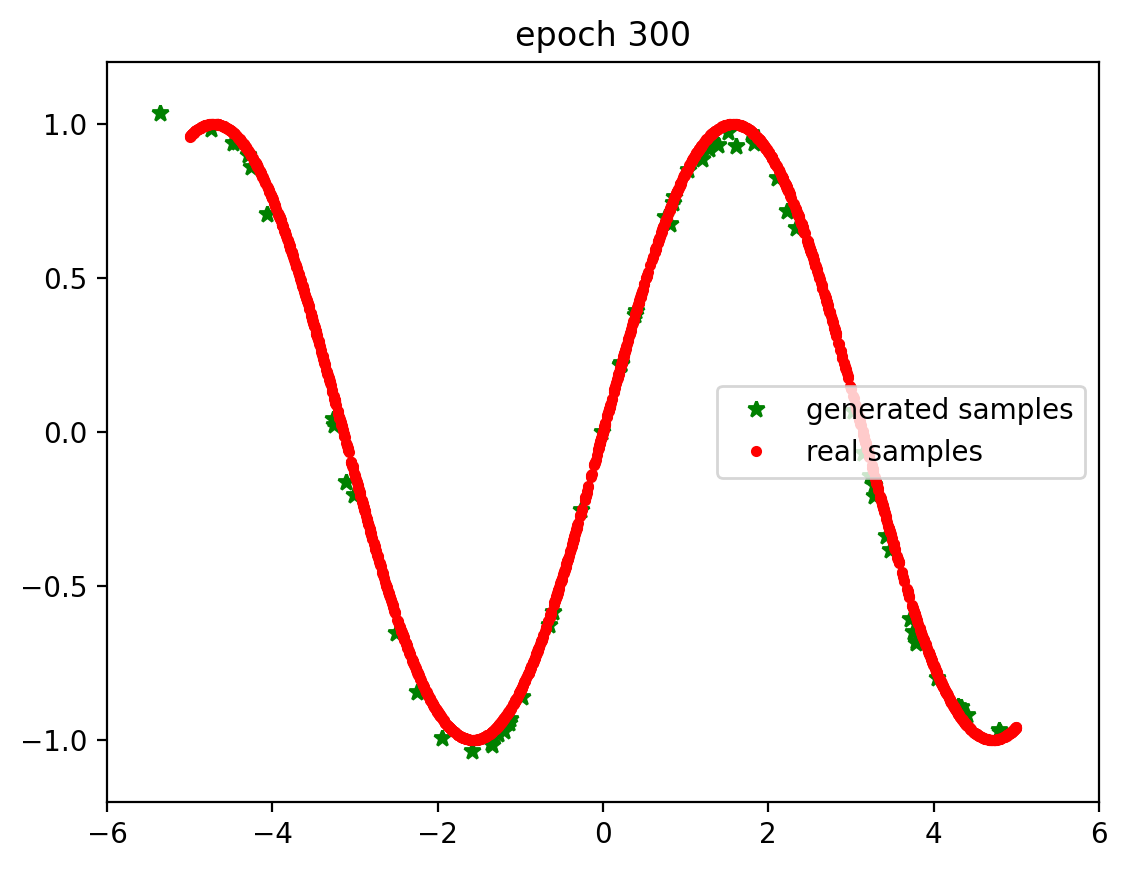

100%|██████████| 300/300 [01:27<00:00,  3.44it/s]


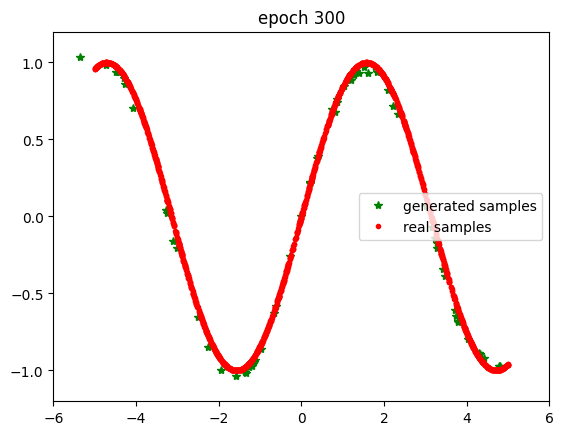

In [41]:
# exercise 3.3
from torch.utils.data import DataLoader

batch_size=64
train_loader=DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True)

import torch.nn as nn
device="cuda" if torch.cuda.is_available() else "cpu"
D=nn.Sequential(
    nn.Linear(2,256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64,1),
    nn.Sigmoid()).to(device)
G=nn.Sequential(
    nn.Linear(2,16),
    nn.ReLU(),
    nn.Linear(16,32),
    nn.ReLU(),
    nn.Linear(32,2)).to(device)

loss_fn=nn.BCELoss()
lr=0.0005
optimD=torch.optim.Adam(D.parameters(),lr=lr)
optimG=torch.optim.Adam(G.parameters(),lr=lr)

real_labels=torch.ones((batch_size,1))
real_labels=real_labels.to(device)

fake_labels=torch.zeros((batch_size,1))
fake_labels=fake_labels.to(device)

def train_D_on_real(real_samples):
    real_samples=real_samples.to(device)
    optimD.zero_grad()
    out_D=D(real_samples)
    loss_D=loss_fn(out_D,real_labels)
    loss_D.backward()
    optimD.step()
    return loss_D
        
def train_D_on_fake():        
    noise=torch.randn((batch_size,2))
    noise=noise.to(device)
    fake_samples=G(noise)        
    optimD.zero_grad()
    out_D=D(fake_samples)
    loss_D=loss_fn(out_D,fake_labels)
    loss_D.backward()
    optimD.step()
    return loss_D

def train_G(): 
    noise=torch.randn((batch_size,2))
    noise=noise.to(device)
    optimG.zero_grad()
    fake_samples=G(noise)
    out_G=D(fake_samples)
    loss_G=loss_fn(out_G,real_labels)
    loss_G.backward()
    optimG.step() 
    return loss_G, fake_samples 

import os
os.makedirs("files", exist_ok=True)

def test_epoch(epoch,gloss,dloss,n):
    if epoch==0 or (epoch+1)%25==0:
        g=gloss.item()/n
        d=dloss.item()/n
        print(f"at epoch {epoch}, G loss: {g}, D loss {d}") 
        fake=fake_samples.detach().cpu().numpy()
        plt.figure(dpi=200)
        plt.plot(fake[:,0],fake[:,1],"*",c="g",
            label="generated samples")
        plt.plot(train_data[:,0],train_data[:,1],".",c="r",
            label="real samples")
        plt.title(f"epoch {epoch+1}")
        plt.xlim(-6,6)
        plt.ylim(-1.2,1.2)
        plt.legend()
        plt.show()

for epoch in tqdm(range(300)):
    gloss=0
    dloss=0
    for n, real_samples in enumerate(train_loader):
        loss_D=train_D_on_real(real_samples)
        dloss+=loss_D
        loss_D=train_D_on_fake()
        dloss+=loss_D
        loss_G,fake_samples=train_G()
        gloss+=loss_G
    test_epoch(epoch,gloss,dloss,n)
    
fake=fake_samples.detach().cpu().numpy()  
plt.figure(dpi=100)
plt.plot(fake[:,0],fake[:,1],"*",c="g",
    label="generated samples")
plt.plot(train_data[:,0],train_data[:,1],".",c="r",
    label="real samples")
plt.title(f"epoch {epoch+1}")
plt.xlim(-6,6)
plt.ylim(-1.2,1.2)
plt.legend()
plt.show() 

In [42]:
# exercise 3.4
import torch
torch.manual_seed(0)
def onehot_encoder(position,depth):
    onehot=torch.zeros((depth,))
    onehot[position]=1
    return onehot

def int_to_onehot(number):
    onehot=onehot_encoder(number,100)
    return onehot

def onehot_to_int(onehot):  
    num=torch.argmax(onehot)
    return num.item()

def gen_sequence():
    indices = torch.randint(0, 34, (10,))
    values = torch.tensor(indices)*3
    return values  

sequence=gen_sequence()


def gen_batch():
    sequence=gen_sequence()
    batch=[int_to_onehot(i).numpy() for i in sequence]
    return torch.tensor(batch)
batch=gen_batch()



def data_to_num(data):
    num=torch.argmax(data,dim=-1)
    return num
numbers=data_to_num(batch)


import torch.nn as nn
# determine the device automatically
device="cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
D=nn.Sequential(
    nn.Linear(100,1),
    nn.Sigmoid()).to(device)
G=nn.Sequential(
    nn.Linear(100,100),
    nn.ReLU()).to(device)
loss_fn=nn.BCELoss()
lr=0.0005
optimD=torch.optim.Adam(D.parameters(),lr=lr)
optimG=torch.optim.Adam(G.parameters(),lr=lr)

real_labels=torch.ones((10,1)).to(device)
fake_labels=torch.zeros((10,1)).to(device)

def train_D_G():
    # Generate examples of even real data
    true_data=gen_batch().to(device)
    # use 1 as labels since they are real
    preds=D(true_data)
    loss_D1=loss_fn(preds,real_labels)
    optimD.zero_grad()
    loss_D1.backward()
    optimD.step()
    # train D on fake data
    noise=torch.randn(10,100).to(device)
    generated_data=G(noise)
    # use 0 as labels since they are fake
    preds=D(generated_data)
    loss_D2=loss_fn(preds,fake_labels)
    optimD.zero_grad()
    loss_D2.backward()
    optimD.step()
    
    # train G 
    noise=torch.randn(10,100).to(device)
    generated_data=G(noise)
    # use 1 as labels since G wants to fool D
    preds=D(generated_data)
    loss_G=loss_fn(preds,real_labels)
    optimG.zero_grad()
    loss_G.backward()
    optimG.step()
    return generated_data       

class EarlyStop:
    def __init__(self, patience=1000):    #A
        self.patience = patience
        self.steps = 0
        self.min_gdif = float('inf')
    def stop(self, gdif):    #B
        if gdif < self.min_gdif:    #C
            self.min_gdif = gdif
            self.steps = 0
        elif gdif >= self.min_gdif:
            self.steps += 1
        if self.steps >= self.patience:    #D
            return True
        else:
            return False
stopper=EarlyStop(800)
mse=nn.MSELoss()
def distance(generated_data):
    nums=data_to_num(generated_data)
    remainders=nums%5
    ten_zeros=torch.zeros((10,1)).to(device)
    mseloss=mse(remainders,ten_zeros)
    return mseloss
for i in range(10000):
    # train discriminator on real data
    gloss=0
    dloss=0
    generated_data=train_D_G()  
    dis=distance(generated_data)
    if stopper.stop(dis)==True:
        break
    if i % 50 == 0:
        print(data_to_num(generated_data))

scripted = torch.jit.script(G) 
scripted.save('files/num_gen3.pt') 

new_G=torch.jit.load('files/num_gen3.pt',
                     map_location=device)    #A
new_G.eval()
noise=torch.randn((10,100)).to(device)    #B
new_data=new_G(noise)    #C 
print(data_to_num(new_data))

<ipython-input-42-0b48164b8099>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  values = torch.tensor(indices)*3
<ipython-input-42-0b48164b8099>:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch)


tensor([ 1, 47, 89, 95, 54, 49, 75, 22, 28, 95])
tensor([65, 98, 67, 25, 53, 62, 74, 35, 96, 52])
tensor([12, 80, 55, 66, 36, 48, 44, 66, 55, 44])
tensor([30, 96, 53, 16, 46, 50, 76, 79, 64,  3])
tensor([72,  9, 10, 37,  6, 58, 79, 35, 32, 96])
tensor([ 3, 30,  1,  8, 58, 23, 37, 30, 12, 79])
tensor([74, 30, 72, 72, 64,  7, 10, 79,  3,  1])
tensor([43, 96, 32, 30,  3,  3, 32, 10, 30, 70])
tensor([ 0, 92, 30, 30, 43, 23, 72, 53, 72, 46])
tensor([72, 72,  1, 93, 30, 43, 96, 30, 58,  3])
tensor([70, 30, 66, 72, 72,  3, 27, 30,  8, 30])
tensor([93, 84,  8, 79, 93, 66,  3, 53,  7, 72])
tensor([53,  3, 93, 42, 70, 30, 72, 30, 48,  3])
tensor([42,  0, 72, 76, 32, 96, 90, 21, 64, 51])
tensor([87, 48,  0, 68, 58, 43, 64, 30, 96, 70])
tensor([ 3,  0,  0,  0, 54, 39,  0,  0, 21, 84])
tensor([ 0, 48, 33, 60, 21, 72, 57, 60, 21, 41])
tensor([ 0, 84, 15, 21, 60, 60, 54,  3, 54,  3])
tensor([36, 78, 21, 60,  0, 21, 21, 54,  9,  0])
tensor([36, 36, 60, 60, 60, 60, 78, 54, 60, 60])
tensor([90, 33, 36, 